<a href="https://colab.research.google.com/github/marcochisci/Anomaly_detection/blob/main/1day_Anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airqino table Data
Average data values (every day) of every month since July to predict the anomalies in the last 72 days of the selected data

In [ ]:
import pandas as pd
import psycopg2
import pytz
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline


conn = psycopg2.connect(host='playground.magentalab.it', port='45432', database='airqino', user='datareader', password='homntLZnlhQd9prtVA9SFezQek')

query=""" select time_bucket('1 day', c."Dates" ) as "bucket", avg(c."O3") as "O3" ,  avg(c."PM2.5") as "PM2.5", avg(c."CO2") as "CO2",
 avg(c."Temp. int.") as "Temp. int.",  avg(c."T") as "T",  avg(c."PM10") as "PM10", avg(c."RH") as "RH", avg(c."NO2") as 
 "NO2", avg(c."CO") as "CO", avg(c."VOC") as "VOC"
from (select * from crosstab(
  'select sd.data_acquired as timestamp, s.sensor_type ,  sd.float_value as value 
from station_data sd join sensor s on s.id = sd.sensor_id
where sd.data_acquired >= to_timestamp(''2021-06-01 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
 and sd.data_acquired <= to_timestamp(''2021-12-10 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
and sd.station_id = 23284701 order by sd.data_acquired asc, 1'
 , $$VALUES ('O3'::varchar), ('PM2.5'::varchar), ('CO2'::varchar), ('Temp. int.'::varchar), ('T'::varchar)
 , ('PM10'::varchar), ('RH'::varchar), ('NO2'::varchar), ('CO'::varchar), ('VOC'::varchar)$$
) AS value ("Dates" timestamp, "O3" float, "PM2.5" float, "CO2" float, "Temp. int." float, "T" float, "PM10" float,
"RH" float, "NO2" float, "CO" float, "VOC" float))  c 
group by bucket
order by bucket asc;
 """
df = pd.read_sql(query, conn)
df= df.rename(columns={'bucket': 'Dates'})
df=df.set_index('Dates')
europe = pytz.timezone('Europe/Rome')
df.index = df.index.tz_localize(pytz.utc).tz_convert(europe)
#make the dates a string
df.reset_index(level=0, inplace=True)
df['Dates']= df['Dates'].astype(str)
for i in range(len(df)):
  df['Dates'][i]=datetime.datetime.strptime(df['Dates'][i], '%Y-%m-%d %H:%M:%S%z').strftime('%Y-%m-%d %H')
df=df.set_index('Dates')
#fix temp int
df['Temp. int.'] = df['Temp. int.'].div(100)
df['T'] = df['T'].div(10)
df=df.dropna()


display(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-06-29 02,483.896226,1.233491,408.165094,44.318208,30.026651,6.337264,439.327830,250.622642,225.641509,388.389151
2021-06-30 02,380.413911,1.814139,407.336374,40.496477,25.754960,9.486887,489.155074,233.526796,215.522235,354.746864
2021-07-01 02,395.915408,2.004532,415.212991,38.247236,23.941541,9.916918,555.025680,268.540785,216.939577,344.956193
2021-07-02 02,403.517876,2.044420,415.290358,38.516121,24.871506,9.417118,580.283857,230.594800,230.172264,350.762730
2021-07-03 02,420.309446,2.426710,414.899023,39.277904,25.629533,8.107492,594.747014,244.323561,235.191097,358.598263
...,...,...,...,...,...,...,...,...,...,...
2021-12-05 01,188.754516,7.756642,433.145590,20.576961,8.830287,17.527099,852.565356,85.572795,214.837407,287.044633
2021-12-06 01,169.586281,8.420150,434.942122,17.815338,6.321115,12.010718,633.410504,75.369775,188.624866,281.053591
2021-12-07 01,464.487674,24.535906,480.414791,14.266913,3.010611,34.355841,821.661308,203.072883,205.779207,352.839228


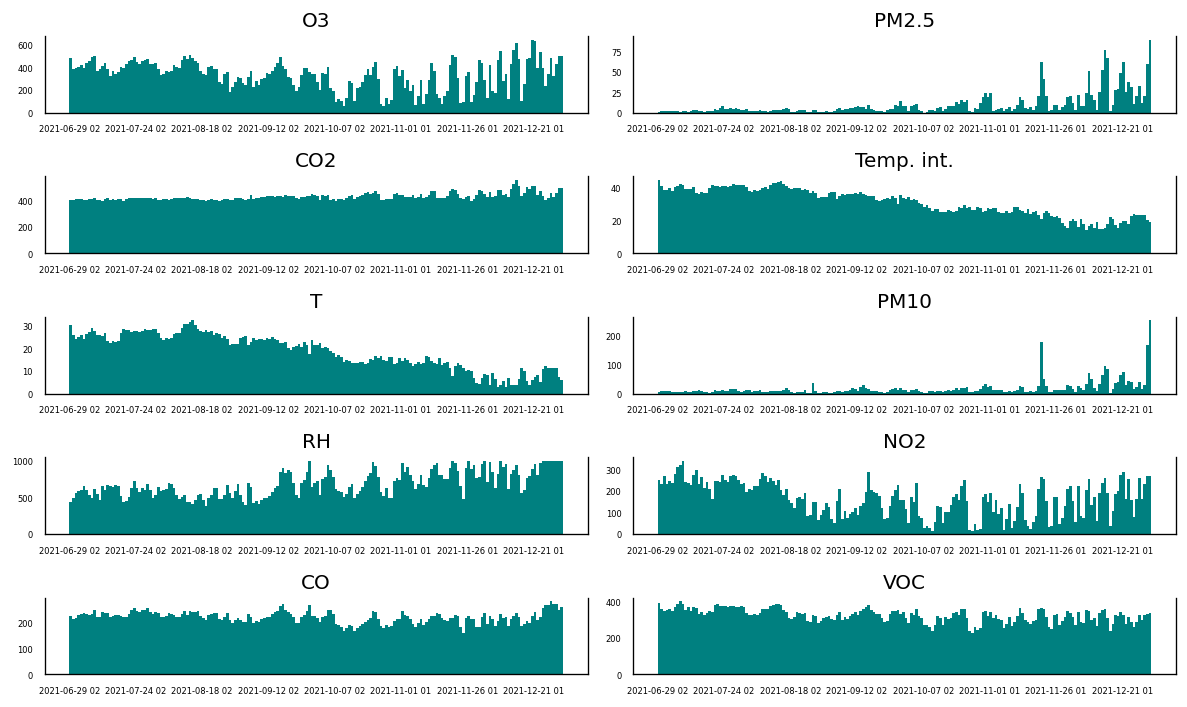

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
x_ticks = np.arange(0, len(df), 25)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.bar(data.index, data, color='teal', align='edge', width=1.0)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=5)
    ax.set_xticks(x_ticks)


plt.tight_layout();

# Wind data

Add the wind (mean)

Int64Index([11896], dtype='int64')


,Wind
Date,
2021-06-29 02,1.29896
2021-06-30 02,2.08958
2021-07-01 02,1.125
2021-07-02 02,1.06354
2021-07-03 02,0.697917
...,...
2021-11-20 01,0.836458
2021-11-21 01,0.60625
2021-11-22 01,1.8375


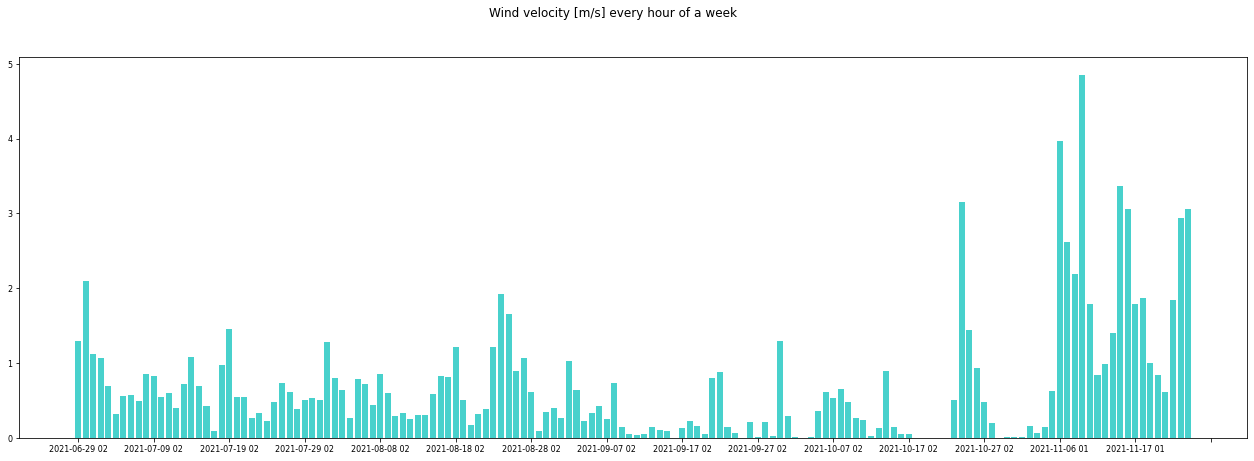

<Figure size 432x288 with 0 Axes>

In [ ]:
wind_temp = pd.read_csv('https://raw.githubusercontent.com/marcochisci/Anomaly_detection/main/anemo.csv')
wind_temp=wind_temp.set_index('Date')
wind_temp=wind_temp.loc['2021-06-29 02:00':'2021-11-26 00:00']
wind_temp.reset_index(level=0, inplace=True)
#duplicare i dati dell'ora '2021-10-31 00:00' per evitare problemi con fuso orario
index_change=wind_temp[wind_temp['Date']=='2021-10-31 00:00'].index
print(index_change)
line = pd.DataFrame({"Date": ['2021-10-31 00:00','2021-10-31 00:15', '2021-10-31 00:30', '2021-10-31 00:45'], " Velocità [m/s]": [0,0,0,0]})
wind_temp = pd.concat([wind_temp.iloc[:11896], line, wind_temp.iloc[11896:]]).reset_index(drop=True)
wind_temp=wind_temp.drop([' Potenza'], axis=1)
#ogni giorno fa la media, 96 valori (ogni 15 minuti 1 valore)
num_values=96
how_many=int(len(wind_temp)/num_values)
wind_df=pd.DataFrame(columns=wind_temp.columns)
for i in range(how_many):
  value=0
  for j in range(num_values):
    value=value+wind_temp[' Velocità [m/s]'][i*num_values+j]
  value=value/num_values
  wind_df.loc[i,:]=[wind_temp['Date'][i*num_values],value]
#cambia formato delle date
for i in range(len(wind_df)):
  wind_df['Date'][i]=datetime.datetime.strptime(wind_df['Date'][i], "%Y-%m-%d %H:%M").strftime('%Y-%m-%d %H')
wind_df=wind_df.set_index('Date')
wind_df= wind_df.rename(columns={' Velocità [m/s]': 'Wind'})
display(wind_df)

# Plot
data_wind=wind_df['Wind']
plt.figure(figsize=(22, 7))
plt.bar(wind_df.index, data_wind, color='mediumturquoise',align='edge', linewidth=1)
# Decorations
x_ticks = np.arange(0, 160, 10)
plt.xticks(x_ticks)
plt.tick_params(labelsize=8)
plt.suptitle('Wind velocity [m/s] every hour of a week')
plt.show()

plt.tight_layout();


Add the wind (median value)

Int64Index([11896], dtype='int64')


,Wind
Date,
2021-06-29 02,0.95
2021-06-30 02,1.85
2021-07-01 02,0.9
2021-07-02 02,0.8
2021-07-03 02,0.5
...,...
2021-12-05 01,1.2
2021-12-06 01,1.3
2021-12-07 01,0.8


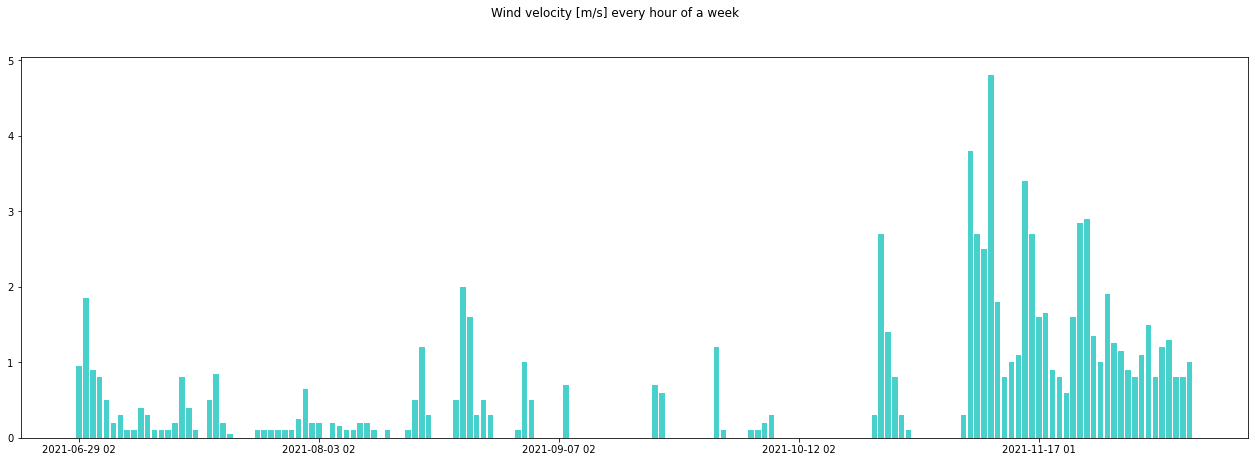

<Figure size 432x288 with 0 Axes>

In [ ]:
import statistics

wind_temp = pd.read_csv('https://raw.githubusercontent.com/marcochisci/Anomaly_detection/main/anemo.csv')
wind_temp=wind_temp.set_index('Date')
wind_temp=wind_temp.loc['2021-06-29 02:00':'2021-12-10 01:00']
wind_temp.reset_index(level=0, inplace=True)
#duplicare i dati dell'ora '2021-10-31 00:00' per evitare problemi con fuso orario
index_change=wind_temp[wind_temp['Date']=='2021-10-31 00:00'].index
print(index_change)
line = pd.DataFrame({"Date": ['2021-10-31 00:00','2021-10-31 00:15', '2021-10-31 00:30', '2021-10-31 00:45'], " Velocità [m/s]": [0,0,0,0]})
wind_temp = pd.concat([wind_temp.iloc[:11896], line, wind_temp.iloc[11896:]]).reset_index(drop=True)
wind_temp=wind_temp.drop([' Potenza'], axis=1)
#ogni giorno fa la media, 96 valori (ogni 15 minuti 1 valore)
num_values=96
how_many=int(len(wind_temp)/num_values)
wind_df=pd.DataFrame(columns=wind_temp.columns)
for i in range(how_many):
  values=[]
  for j in range(num_values):
    values.append(wind_temp[' Velocità [m/s]'][i*num_values+j])
  value=statistics.median(values)
  wind_df.loc[i,:]=[wind_temp['Date'][i*num_values],value]
#cambia formato delle date
for i in range(len(wind_df)):
  wind_df['Date'][i]=datetime.datetime.strptime(wind_df['Date'][i], "%Y-%m-%d %H:%M").strftime('%Y-%m-%d %H')
wind_df=wind_df.set_index('Date')
wind_df= wind_df.rename(columns={' Velocità [m/s]': 'Wind'})
display(wind_df)

# Plot
data_wind=wind_df['Wind']
plt.figure(figsize=(22, 7))
plt.bar(wind_df.index, data_wind, color='mediumturquoise', linewidth=1)
# Decorations
x_ticks = np.arange(0, len(wind_df), 35)
plt.xticks(x_ticks)
plt.suptitle('Wind velocity [m/s] every hour of a week')
plt.show()

plt.tight_layout();


Join the dataframes together, only get the rows that have all the values

In [ ]:
df=df.join(wind_df, how='outer')
df=df.dropna()
#there are two index here
display(df)


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Wind
2021-06-29 02,483.896226,1.233491,408.165094,44.318208,30.026651,6.337264,439.327830,250.622642,225.641509,388.389151,0.95
2021-06-30 02,380.413911,1.814139,407.336374,40.496477,25.754960,9.486887,489.155074,233.526796,215.522235,354.746864,1.85
2021-07-01 02,395.915408,2.004532,415.212991,38.247236,23.941541,9.916918,555.025680,268.540785,216.939577,344.956193,0.9
2021-07-02 02,403.517876,2.044420,415.290358,38.516121,24.871506,9.417118,580.283857,230.594800,230.172264,350.762730,0.8
2021-07-03 02,420.309446,2.426710,414.899023,39.277904,25.629533,8.107492,594.747014,244.323561,235.191097,358.598263,0.5
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-05 01,188.754516,7.756642,433.145590,20.576961,8.830287,17.527099,852.565356,85.572795,214.837407,287.044633,1.2
2021-12-06 01,169.586281,8.420150,434.942122,17.815338,6.321115,12.010718,633.410504,75.369775,188.624866,281.053591,1.3
2021-12-07 01,464.487674,24.535906,480.414791,14.266913,3.010611,34.355841,821.661308,203.072883,205.779207,352.839228,0.8
2021-12-08 01,541.637527,50.832623,485.291045,16.535661,3.894883,72.502132,990.261194,255.243070,234.841151,346.028785,0.8


# Preparations

In [ ]:
df_copy= df.copy()

In [ ]:
pip install fitter

# VAR model mahalanobis

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df, col)
    for col in df.columns
}
adf_test_results     

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


{'CO': 'Stationary',
 'CO2': 'Non-Stationary',
 'NO2': 'Non-Stationary',
 'O3': 'Non-Stationary',
 'PM10': 'Non-Stationary',
 'PM2.5': 'Non-Stationary',
 'RH': 'Non-Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary'}

Converting to stationary with differencing

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in df.columns:
    df[col] = differencing(df, col, 1)

Test for stationarity now

Finding the best lag for VAR model (if the max_lag value is too high the model may not work)

In [ ]:
from statsmodels.tsa.api import VAR
max_lag = 12
var_model = VAR(df)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic
print(selected_lag)

12


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Calculating the errors

In [ ]:
import numpy as np
import scipy as sp

#mahalanobis distance
def mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()
var = VAR(df)
var_fitresults = var.fit(selected_lag)
var_summarymaha=str(var_fitresults.summary())
print(var_summarymaha[0:624])
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[selected_lag:], columns=df.columns)
errors = mahalanobis(x=var_fit_df, data= df)
errors_df=pd.DataFrame(errors, index=df_copy.index[selected_lag:], columns={"errors"})

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Jan, 2022
Time:                     13:54:55
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    61.4982
Nobs:                     174.000    HQIC:                   48.4417
Log likelihood:          -4698.06    FPE:                3.82775e+18
AIC:                      39.5300    Det(Omega_mle):     1.95082e+16
--------------------------------------------------------------------



# Testing the mahalanobis errors' distribution and finding the thresholds

Make a histogram

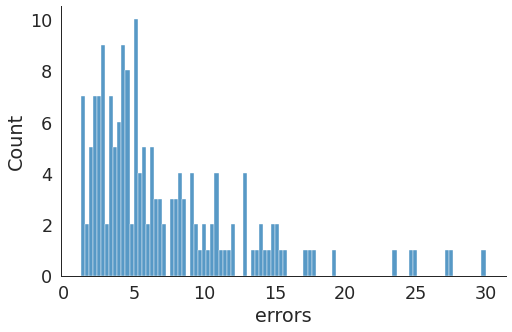

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats
#remove outliers
z_scores = stats.zscore(errors_df)

abs_z_scores = np.abs(z_scores)
filtered_errors = (abs_z_scores < 3).all(axis=1)
new_errors_df = errors_df[filtered_errors]

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=new_errors_df, x="errors", kind="hist", bins = 100, aspect = 1.5)

Find the best distribution (the output ranks the best distributions in ascending order)

          sumsquare_error         aic          bic  kl_div
lognorm          0.071873  862.874873 -1305.264149     inf
invgauss         0.071935  860.038403 -1305.116769     inf
gamma            0.072140  859.942920 -1304.632279     inf
pearson3         0.072141  859.943538 -1304.631589     inf
beta             0.072170  861.503084 -1299.425627     inf


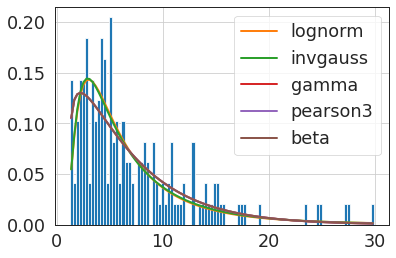

In [ ]:
er = new_errors_df["errors"].values
er_min=min(er)
er_max=max(er)
f = Fitter(er,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param=f.fitted_param[distribution]

In [ ]:
def get_num_var(distribution):
  if(distribution=='burr' or distribution=='beta'):
    num_var=2
  if(distribution=='invgauss' or distribution=='gamma' or distribution=='weibull_min' or distribution=='weibull_max' or distribution=='lognorm'
         or distribution=='pearson3' or distribution=='triang' ):
    num_var=1
  if(distribution=='expon' or distribution=='norm' or distribution=='uniform' ):
    num_var=0
  return num_var

In [ ]:
from scipy.stats import burr, beta, expon, norm, uniform, weibull_min, weibull_max, invgauss, gamma, lognorm, pearson3, triang

#distributions, convert from string to dis
distributions={"burr": burr, "beta": beta, "invgauss": invgauss, "gamma": gamma, "weibull_min": weibull_min, "weibull_max": weibull_max,
               "lognorm": lognorm, "pearson3": pearson3, "triang": triang, "expon": expon, "norm": norm, "uniform": uniform}

threshold low: 24.526899923718105
threshold med: 32.974495532909835
threshold high: 40.3661416909526


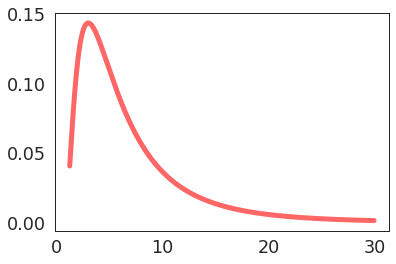

In [ ]:
from scipy.stats import invgauss
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

low, med, high= 0.975, 0.99, 0.995
find= np.linspace(er_min+((er_max-er_min)/1000),er_max*2, 2000)
x = np.linspace(er_min+((er_max-er_min)/1000),er_max, 1000)
dis=distributions[distribution]
num_var=get_num_var(distribution)
if(num_var==0):
    loc, scale = param[0], param[1]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i, loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
#1 variables
if(num_var==1):
  c= param[0]
  loc, scale = param[1], param[2]
  #graph to test if the parameters are correct
  ax.plot(x, dis.pdf(x,c, loc, scale),
       'r-', lw=5, alpha=0.6)
  # using the cdf
  found=0
  for i in find:
    if ((dis.cdf(i, c,loc, scale)>low) & (found<1)):        
      threshold_l=i
      found=1
    if ((dis.cdf(i,c, loc, scale)>med) & (found<2)):
      threshold_m=i
      found=2
    if ((dis.cdf(i,c, loc, scale)>high) & (found<3)):
      threshold_h=i
      found=3
#3 variables
if(num_var==2):
  c,d= param[0], param[1]
  loc, scale = param[2], param[3]
  #graph to test if the parameters are correct
  ax.plot(x, dis.pdf(x,c,d, loc, scale),
       'r-', lw=5, alpha=0.6)

  # using the cdf
  found=0
  for i in find:
    if ((dis.cdf(i,c,d, loc, scale)>low) & (found<1)):
      threshold_l=i
      found=1
    if ((dis.cdf(i,c,d, loc, scale)>med) & (found<2)):
      threshold_m=i
      found=2
    if ((dis.cdf(i,c,d, loc, scale)>high) & (found<3)):
      threshold_h=i
      found=3
print('threshold low: '+str(threshold_l))
print('threshold med: '+str(threshold_m))
print('threshold high: '+str(threshold_h))

# Finding anomalies with mahalanobis distance

In [ ]:
#0 means that is it not an anomaly
def find_anomalies(errors, threshold_low, threshold_med, threshold_high):
  predictions=pd.DataFrame(np.zeros((len(errors), 1)))
  for i in range(len(errors)):
    if((errors.iloc[i].values >= threshold_low) &(errors.iloc[i].values < threshold_med)):
      predictions.iloc[i]=1
    if((errors.iloc[i].values >= threshold_med) &(errors.iloc[i].values < threshold_high)):
      predictions.iloc[i]=2
    if(errors.iloc[i].values >= threshold_high):
      predictions.iloc[i]=3
  return predictions

predictions = find_anomalies(abs(errors_df),threshold_l, threshold_m, threshold_h)

Select how many values do you want to predict: there is 1 each day.

In [ ]:
data = df_copy.iloc[selected_lag: , :]
data['Predictions'] = predictions.values
how_many=72
data=data.iloc[-how_many:,:]
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-10-21 02,404.172747,14.978541,463.022532,27.266652,14.845601,18.341202,981.137339,223.212446,245.706009,354.824034,0.0
2021-10-22 02,441.784270,12.742697,474.108989,29.163337,16.727416,17.426966,925.458427,250.313483,242.134831,356.952809,0.0
2021-10-23 02,297.971953,15.548004,452.476807,27.355642,15.665912,23.149946,784.892125,153.966559,214.839266,310.135922,0.0
2021-10-24 02,76.783172,2.124056,410.094930,27.890410,16.478749,4.062567,568.887810,18.880259,187.343042,238.579288,0.0
2021-10-25 02,59.653148,1.442903,403.967983,26.356051,14.778762,3.648879,520.229456,14.147279,178.033084,227.529349,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27 01,483.067093,32.667732,458.268371,23.202503,11.223110,41.583600,998.897764,259.774228,283.235357,326.759318,0.0
2021-12-28 01,324.618743,11.958466,428.230032,23.219968,11.277423,14.250266,999.000000,164.288605,273.621938,296.828541,0.0
2021-12-29 01,425.167377,20.421109,459.434968,22.925661,11.100640,29.762260,998.980810,231.191898,274.404051,325.236674,0.0


In [ ]:
data['Predictions'].value_counts()

0.0    64
1.0     4
3.0     3
2.0     1
Name: Predictions, dtype: int64

# Showing the anomalies found with Mahalanobis distance with graphs, differenced values

get all the anomalies

In [ ]:
anomalies_l= df.iloc[-how_many:][(data['Predictions'] == 1)]
anomalies_m= df.iloc[-how_many:][(data['Predictions'] == 2)]
anomalies_h= df.iloc[-how_many:][(data['Predictions'] == 3)]

Get the days before to compare

In [ ]:
day_before= df.iloc[-(how_many*2):-how_many,:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError

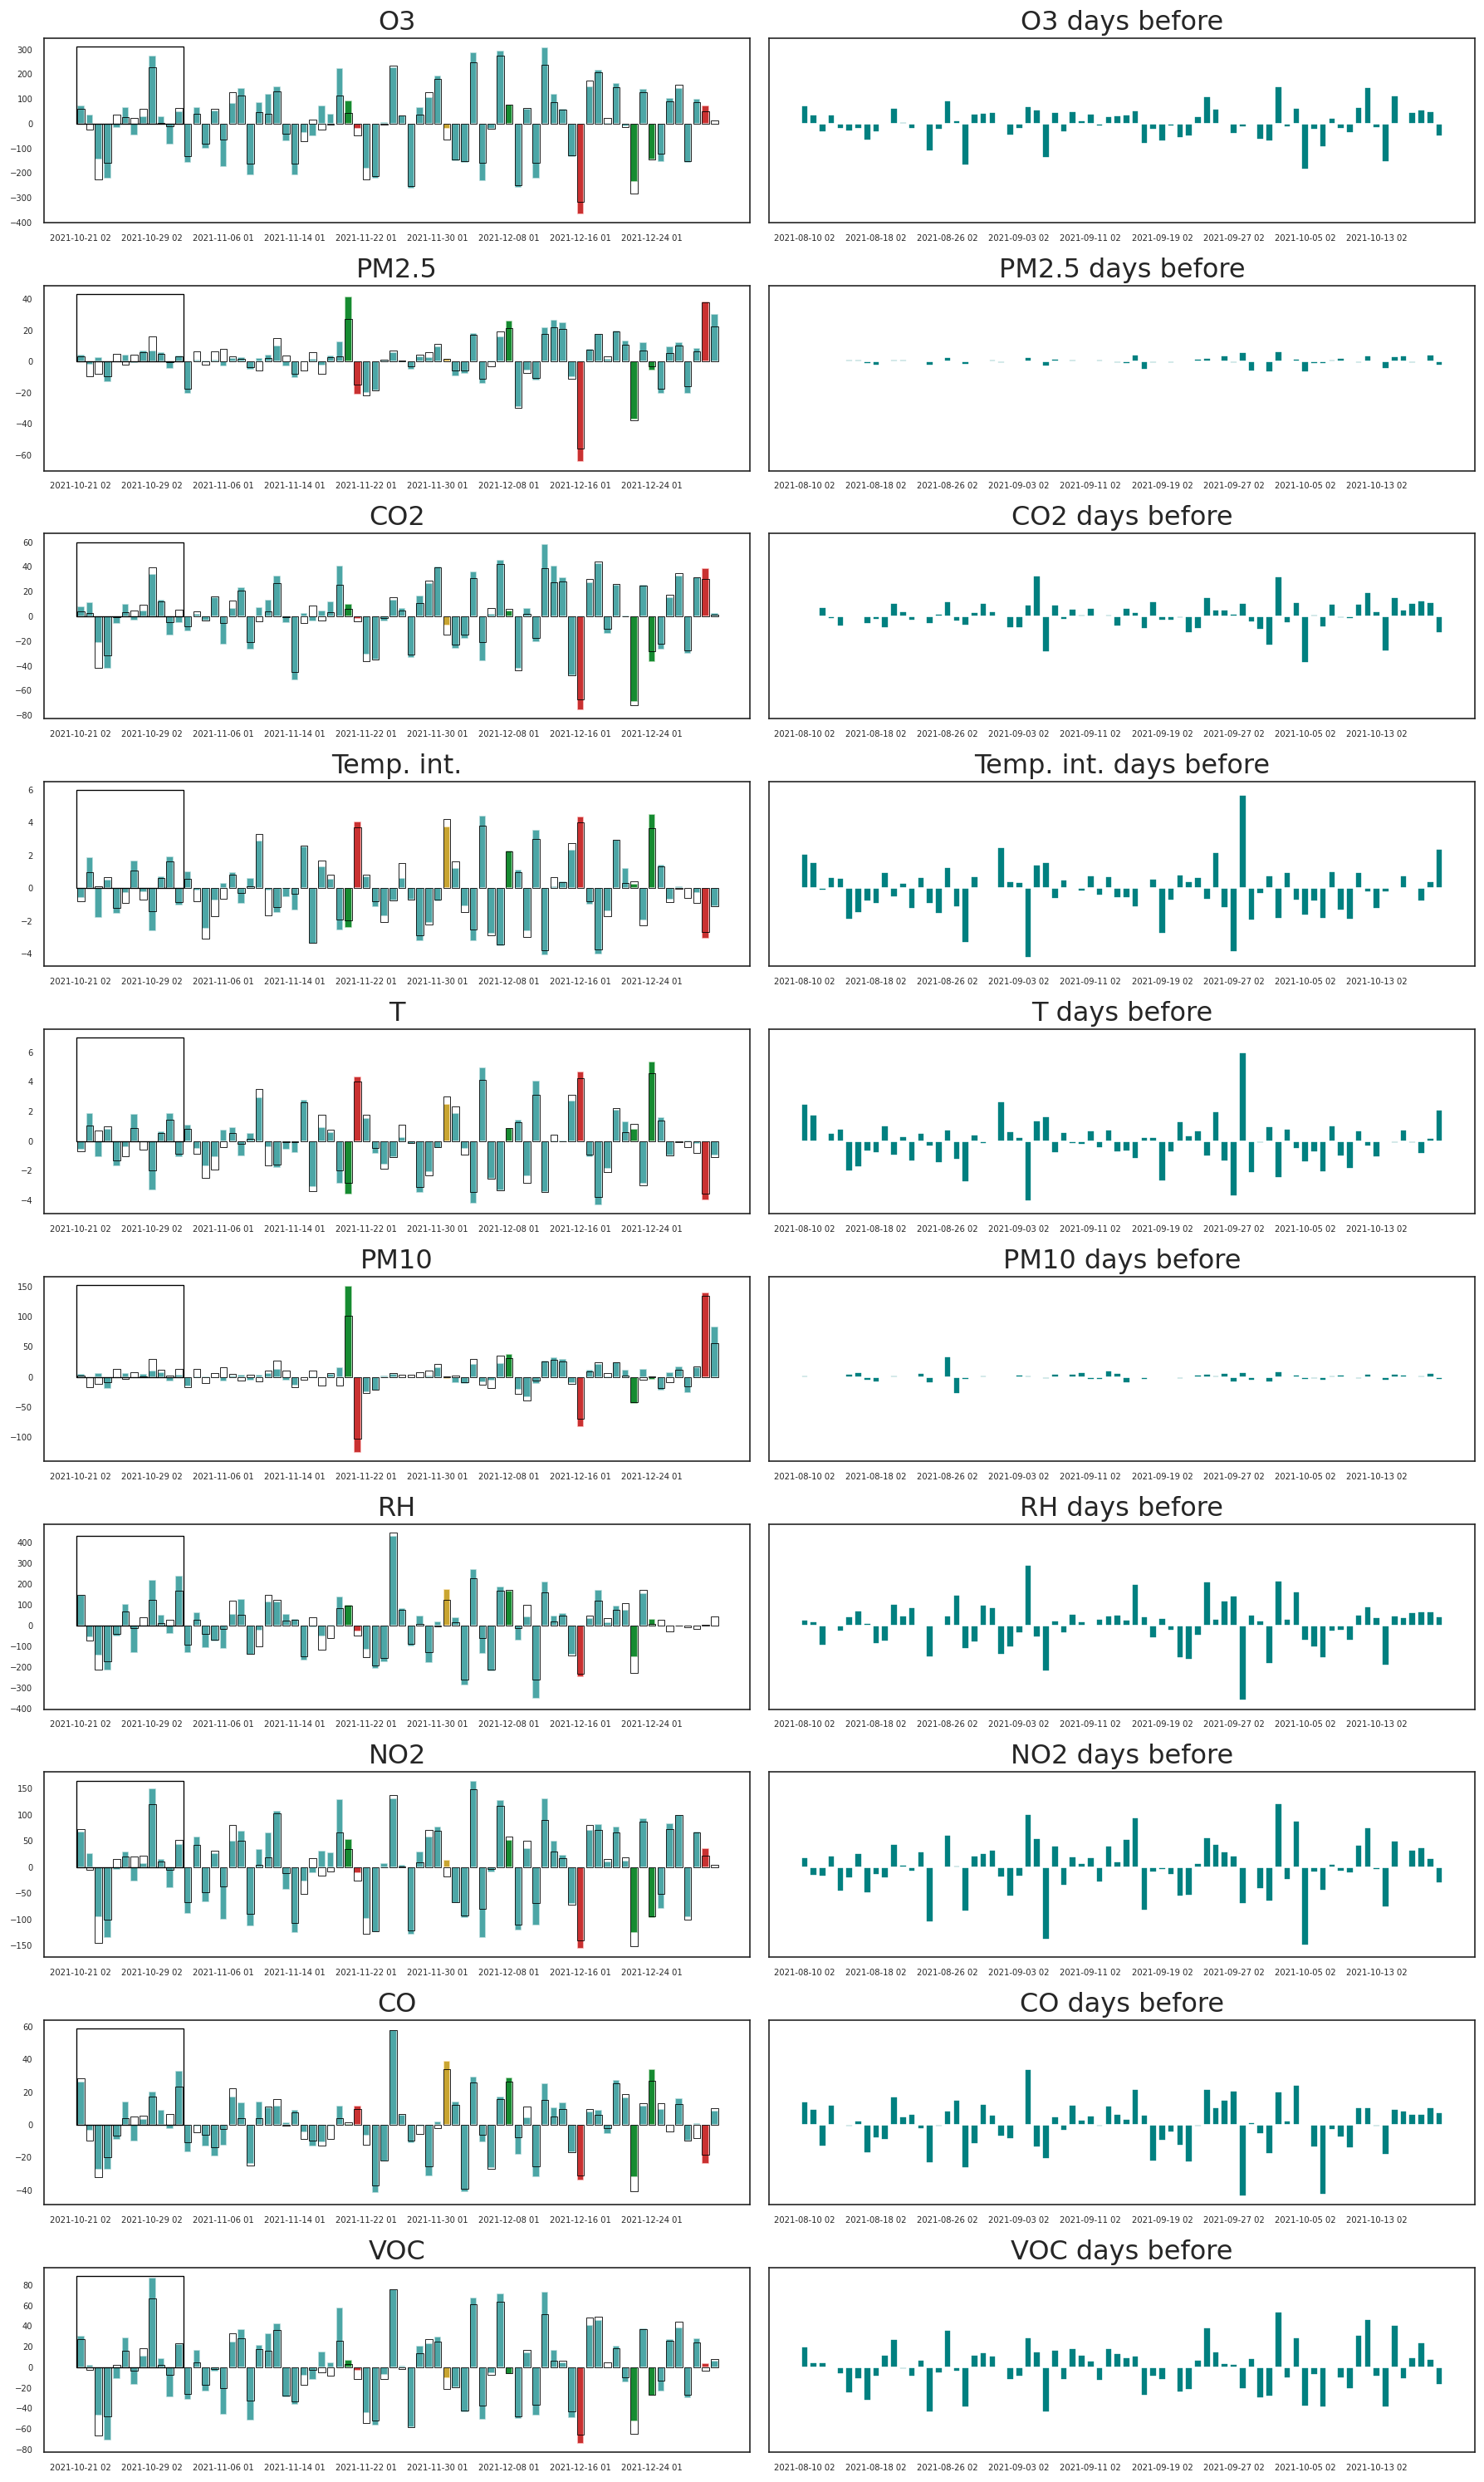

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib
%matplotlib inline

num_col=len(df_copy.columns)
# Plot
fig, axes = plt.subplots(nrows=num_col, ncols=2, sharey='row', dpi=120, figsize=(15,25))
x_ticks = np.arange(0, how_many, 8)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_maha = df.iloc[-how_many:][df.columns[i/2]]
      ax.bar(data_maha.index, data_maha, color='teal', alpha=0.7, linewidth=1)
      ax.set_xticks(x_ticks)
      
      # x axis value list.
      x_number_list_l = list(anomalies_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_l[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', alpha=0.7,  linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_m[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange',alpha=0.7,  linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_h[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red',alpha=0.7, linewidth=1)
      #lag rectangle
      left, bottom, width, height = (-0.5, 0, 1*selected_lag, int(max(df.iloc[-how_many:][df.columns[i/2]])+2))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))
      data_expeted= var_fit_df.iloc[-how_many:][df.columns[i/2]]
      ax.bar(data_expeted.index, data_expeted ,fill = False, edgecolor = 'black', linewidth=0.5)

      # Decorations
      ax.set_title(df.columns[i/2])
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before[df.columns[(i-1)/2]]
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      # Decorations
      ax.set_title(df.columns[(i-1)/2]+' days before')
      ax.tick_params(labelsize=6)
      ax.set_xticks(x_ticks)

plt.tight_layout();


# Showing the anomalies found with Mahalanobis distance with graphs

get all the anomalies

In [ ]:
anomalies_l= data[(data['Predictions'] == 1)]
anomalies_m= data[(data['Predictions'] == 2)]
anomalies_h= data[(data['Predictions'] == 3)]

Get the day before to compare

In [ ]:
day_before= df_copy.iloc[-(how_many*2):-how_many,:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError

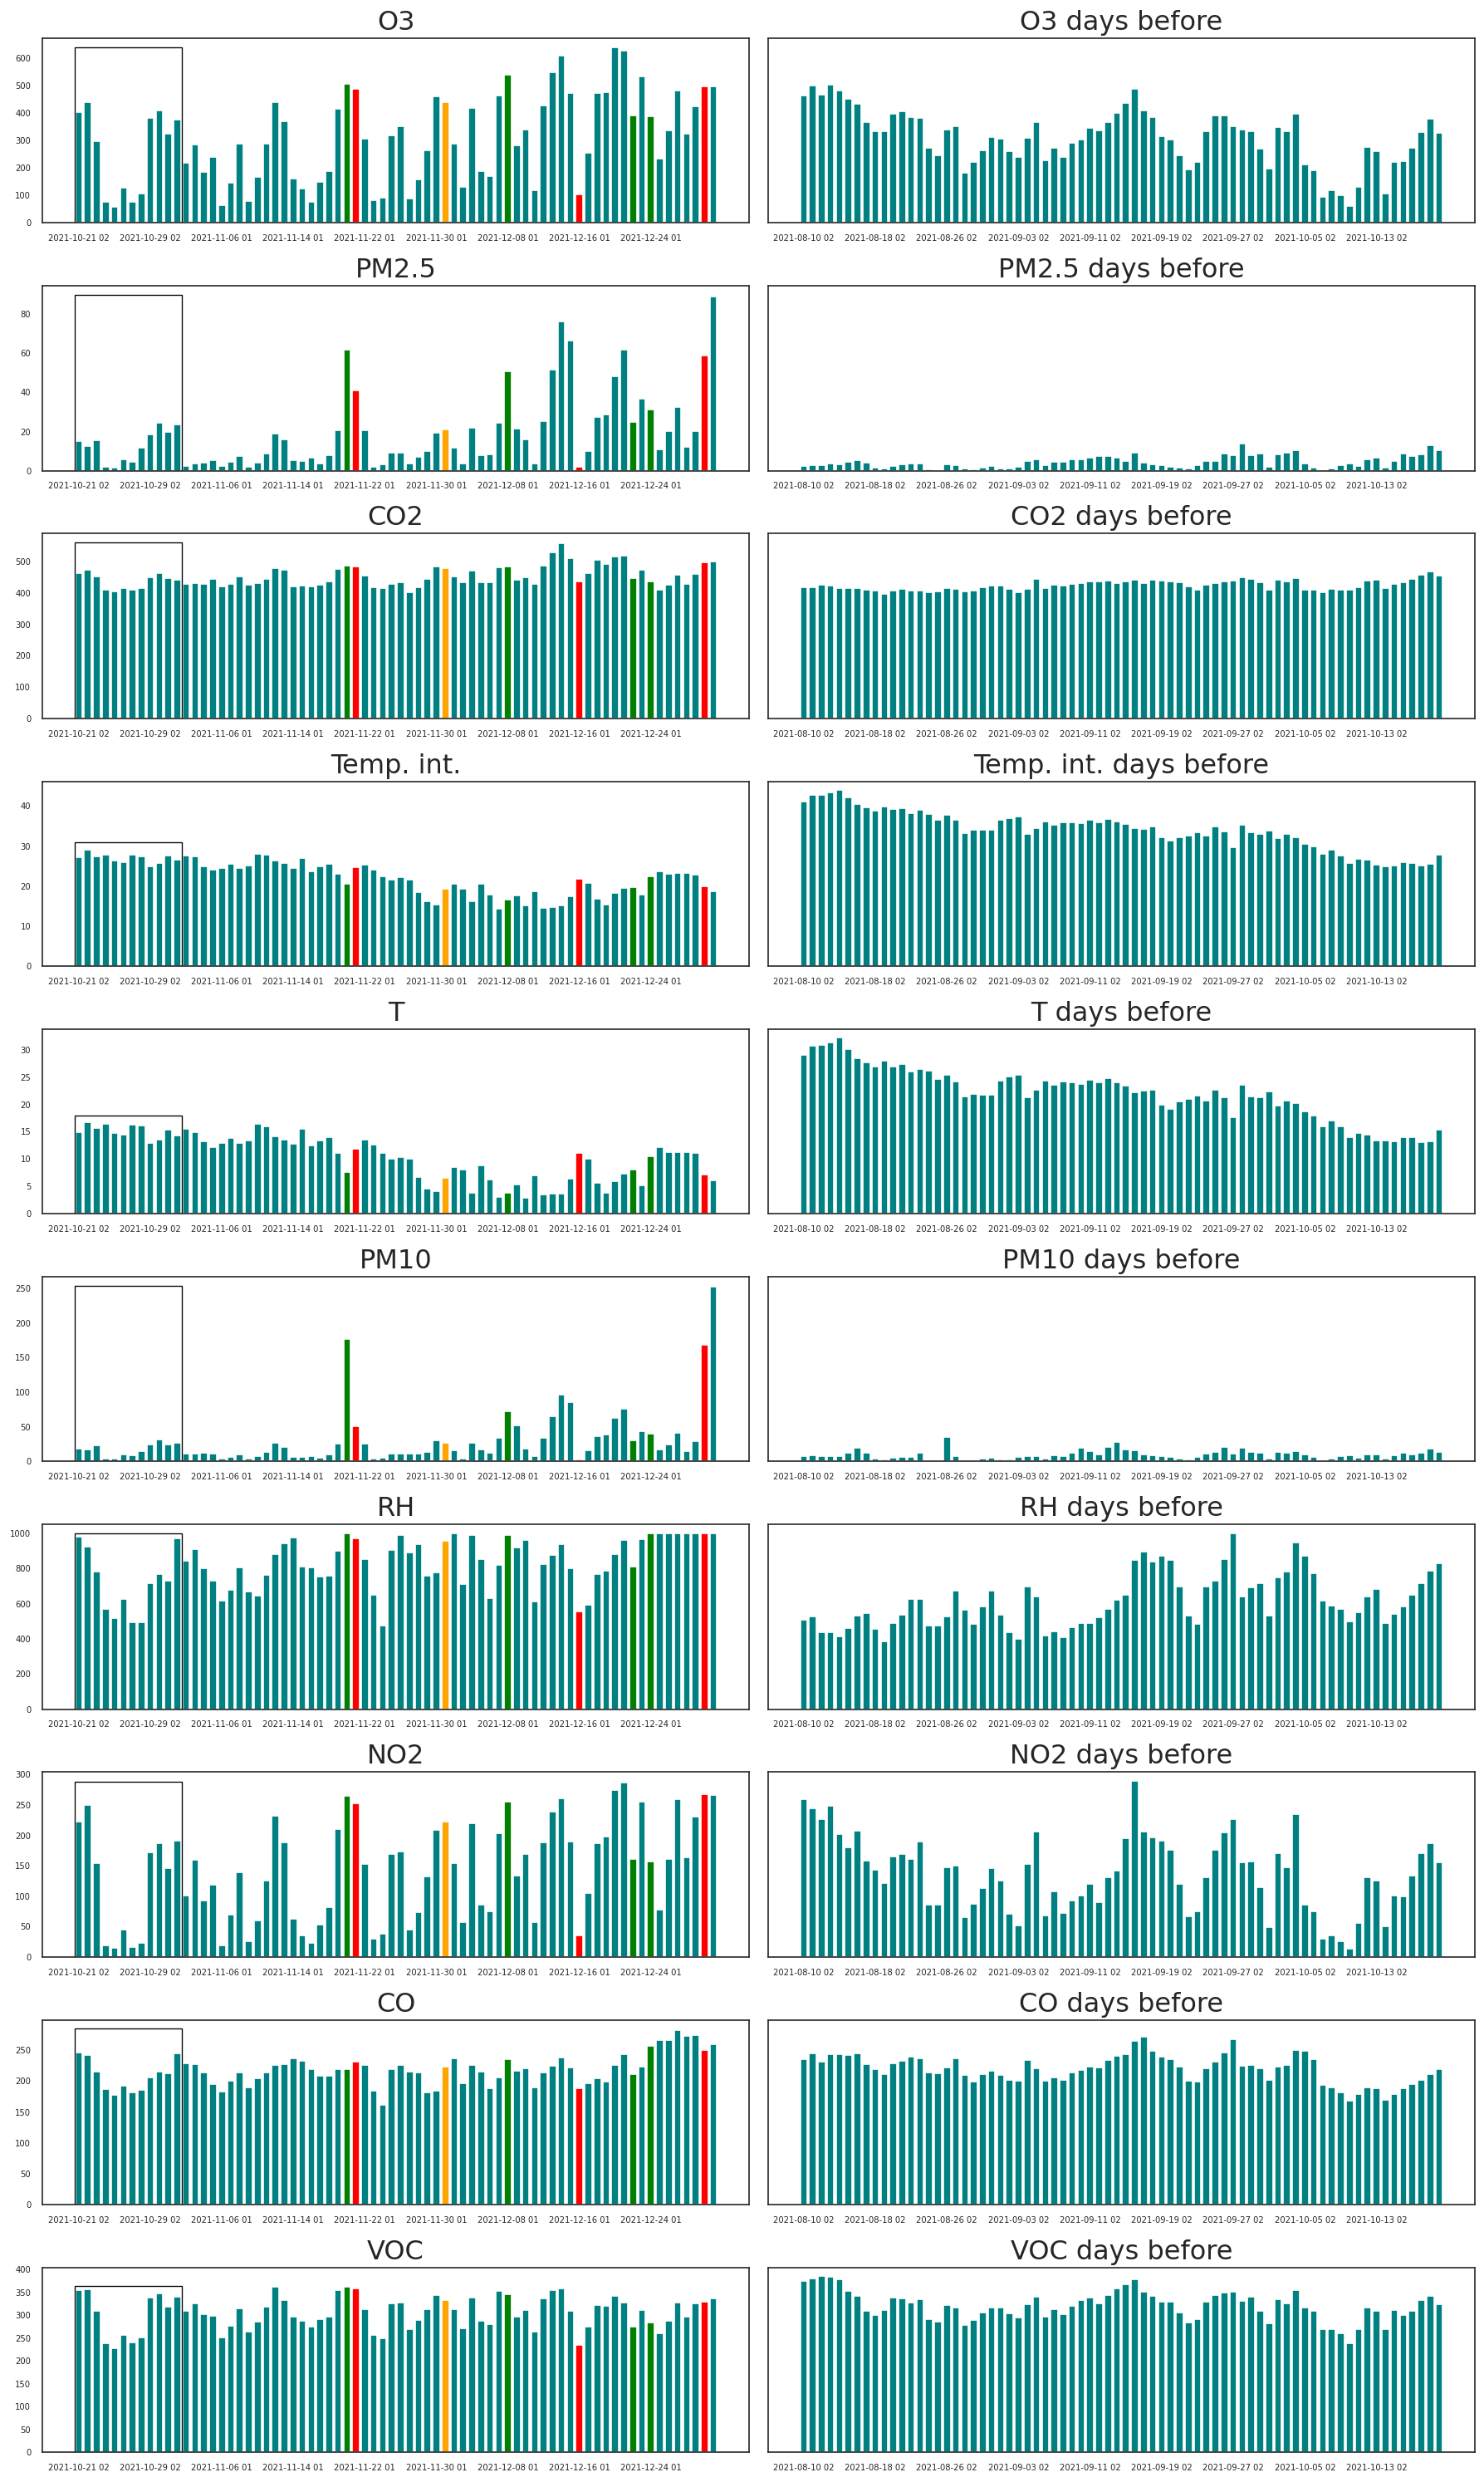

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib
%matplotlib inline

num_col=len(df_copy.columns)
# Plot
fig, axes = plt.subplots(nrows=num_col, ncols=2, sharey='row', dpi=120, figsize=(15,25))
x_ticks = np.arange(0, how_many, 8)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_maha = data[df.columns[i/2]]
      ax.bar(data_maha.index, data_maha, color='teal', linewidth=1)
      ax.set_xticks(x_ticks)
      
      # x axis value list.
      x_number_list_l = list(anomalies_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_l[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green',  linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_m[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange',  linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_h[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red', linewidth=1)
      #lag rectangle
      left, bottom, width, height = (-0.5, 0, 1*selected_lag, int(max(data[df.columns[i/2]])+2))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))

      # Decorations
      ax.set_title(df.columns[i/2])
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before[df.columns[(i-1)/2]]
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      # Decorations
      ax.set_title(df.columns[(i-1)/2]+' days before')
      ax.tick_params(labelsize=6)
      ax.set_xticks(x_ticks)

plt.tight_layout();


# Searching the anomalies using the euclidian distance for each variable

Testing stationarity

In [ ]:
df_e=df_copy.copy()

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df_e, col)
    for col in df_e.columns
}
adf_test_results     

{'CO': 'Stationary',
 'CO2': 'Non-Stationary',
 'NO2': 'Non-Stationary',
 'O3': 'Non-Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Non-Stationary',
 'RH': 'Non-Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary'}

Converting to stationary with differencing.

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in df_e.columns:
    df_e[col] = differencing(df_e, col, 1)

In [ ]:
from statsmodels.tsa.api import VAR
max_lag = 14
var_model = VAR(df_e)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag_eucl = lag_results.aic
print(selected_lag_eucl)

14


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
import numpy as np
import scipy as sp

#euclidian distance
def euclidian(x=None, data=None):
  distance = pd.DataFrame(index=df_copy.index[selected_lag_eucl:], columns=data.columns)
  for col in data.columns:
    distance[col]=abs((x[col]).values-(data[col]).values)
  return distance
var = VAR(df_e)
var_fitresults = var.fit(selected_lag_eucl)
var_summaryeucl=str(var_fitresults.summary())
print(var_summaryeucl[0:624])
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[selected_lag_eucl:], columns=df_e.columns)
distance = euclidian(x=var_fit_df, data= df_e.iloc[selected_lag_eucl:])
display(distance)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Jan, 2022
Time:                     17:33:40
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    16.7575
Nobs:                     150.000    HQIC:                -0.0450723
Log likelihood:           147.276    FPE:                    82.9747
AIC:                     -11.5425    Det(Omega_mle):       0.0806745
--------------------------------------------------------------------



,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-07-13 02,16.739559,0.483028,1.272046,0.275445,0.263538,1.759031,0.725203,5.618257,0.892372,5.412481
2021-07-14 02,18.207804,0.213618,3.401527,0.028247,0.042826,0.006365,3.200931,11.244326,0.849423,6.513864
2021-07-15 02,9.668841,0.292471,1.063205,0.116199,0.185641,0.508840,30.667092,9.849637,2.994190,1.805234
2021-07-16 02,3.909106,0.892508,1.104315,0.261529,0.352134,3.330766,27.880058,5.092292,1.336782,0.190121
2021-07-17 02,2.770287,0.477542,0.338308,0.046440,0.016309,1.967041,5.539055,3.131221,0.749166,0.689556
...,...,...,...,...,...,...,...,...,...,...
2021-12-05 01,2.485462,0.362080,1.351461,0.007668,0.054322,1.524158,0.932289,2.004099,0.800643,0.327188
2021-12-06 01,3.459540,0.865004,2.161539,0.073178,0.081042,2.689579,6.573707,3.890039,1.580298,0.459434
2021-12-07 01,5.332091,0.712865,0.700293,0.111792,0.132423,2.414137,6.327033,4.965400,0.164504,1.123417


# Distributions function code

In [ ]:
from scipy.stats import burr, beta, expon, norm, uniform, weibull_min, weibull_max, invgauss, gamma, lognorm, pearson3, triang
import matplotlib.pyplot as plt



Get how many variables the distribution needs to work correctly

In [ ]:
def get_num_var(distribution):
  if(distribution=='burr' or distribution=='beta'):
    num_var=2
  if(distribution=='invgauss' or distribution=='gamma' or distribution=='weibull_min' or distribution=='weibull_max' or distribution=='lognorm'
         or distribution=='pearson3' or distribution=='triang' ):
    num_var=1
  if(distribution=='expon' or distribution=='norm' or distribution=='uniform' ):
    num_var=0
  return num_var

In [ ]:
#distributions, convert from string to dis
distributions={"burr": burr, "beta": beta, "invgauss": invgauss, "gamma": gamma, "weibull_min": weibull_min, "weibull_max": weibull_max,
               "lognorm": lognorm, "pearson3": pearson3, "triang": triang, "expon": expon, "norm": norm, "uniform": uniform}

Function used to get the thresholds

In [ ]:
def get_thresholds(dis, param, min, max,num_var):
  low, med, high=  0.96,0.98,0.995
  find= np.linspace(min+((max-min)/1000),max*2, 2000)
  x = np.linspace(min+((max-min)/1000),max, 1000)
  fig, ax = plt.subplots(1, 1)
  #0 variables
  if(num_var==0):
    loc, scale = param[0], param[1]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i, loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
  #1 variables
  if(num_var==1):
    c= param[0]
    loc, scale = param[1], param[2]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x,c, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i, c,loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i,c, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i,c, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
  #3 variables
  if(num_var==2):
    c,d= param[0], param[1]
    loc, scale = param[2], param[3]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x,c,d, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i,c,d, loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i,c,d, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i,c,d, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
  return threshold_l, threshold_m, threshold_h

# Testing the distance's distributions and finding the thresholds

Make histograms

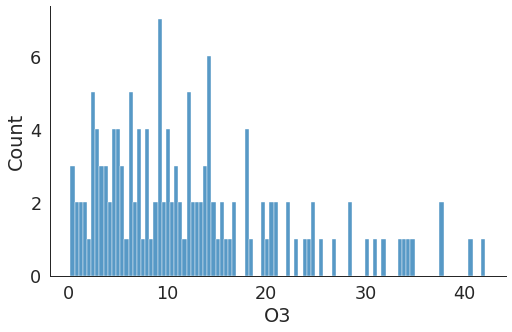

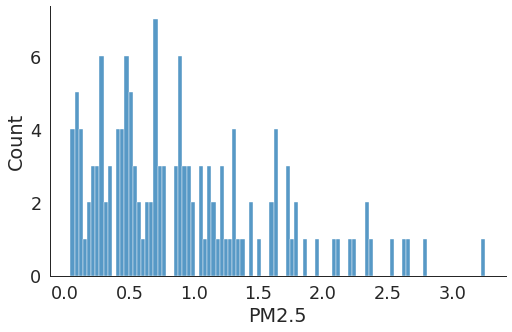

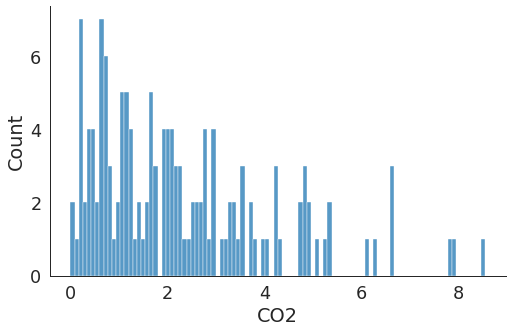

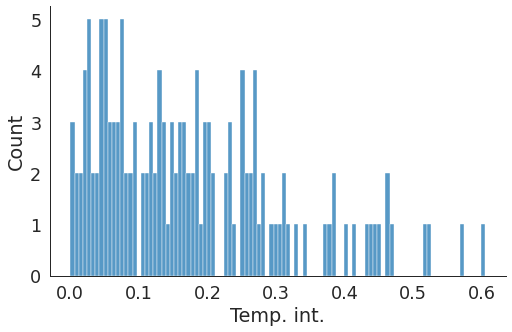

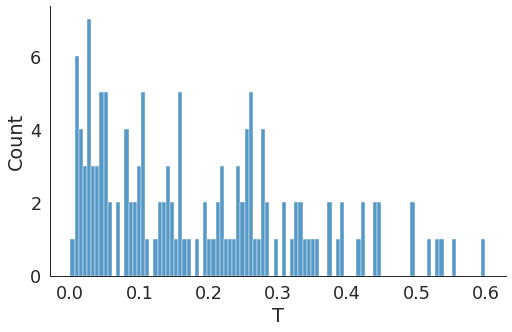

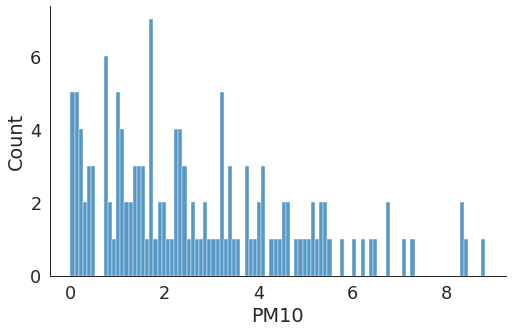

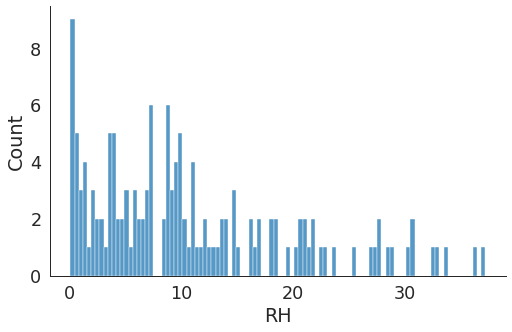

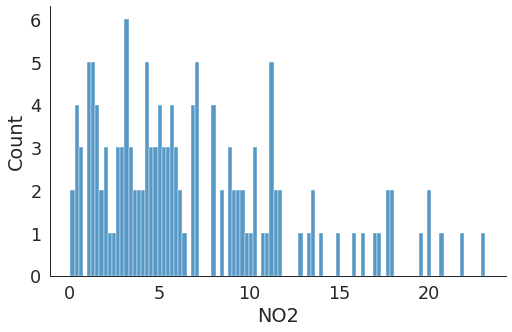

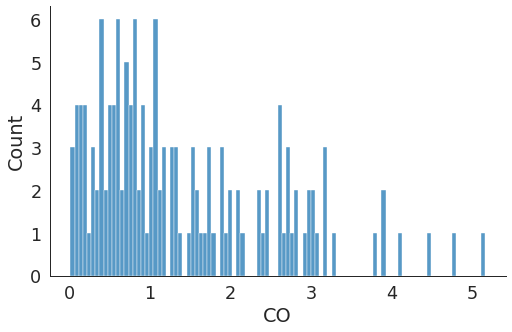

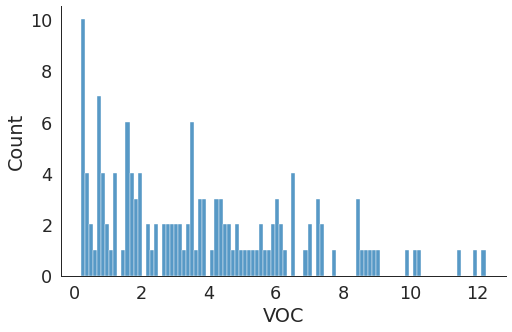

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats

#remove outliers
z_scores = stats.zscore(distance)

abs_z_scores = np.abs(z_scores)
filtered_distance = (abs_z_scores < 3).all(axis=1)
new_distance = distance[filtered_distance]

for col in df.columns:
  sns.set_style('white')
  sns.set_context("paper", font_scale = 2)
  sns.displot(data=new_distance, x=col, kind="hist", bins = 100, aspect = 1.5)

Find the best distribution (the output ranks the best distributions in ascending order)

          sumsquare_error         aic          bic  kl_div
gamma            0.034320  850.260468 -1167.686922     inf
pearson3         0.034320  850.261387 -1167.686879     inf
burr             0.034873  865.837419 -1160.461937     inf
beta             0.034960  840.305598 -1160.107975     inf
invgauss         0.035016  857.522738 -1164.836256     inf


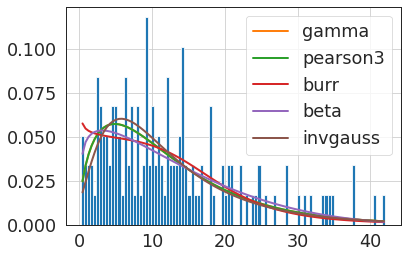

In [ ]:
dis = new_distance["O3"].values
O3_min=min(dis)
O3_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_O=f.fitted_param[distribution]

33.745570025146144 39.7414144458362 51.43960041347623


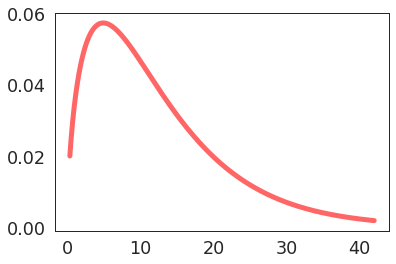

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_O3_l, threshold_O3_m, threshold_O3_h= get_thresholds(dis, param_O, O3_min, O3_max,num_var)
print(threshold_O3_l, threshold_O3_m, threshold_O3_h)


             sumsquare_error         aic         bic  kl_div
burr                7.177523  356.766586 -404.028626     inf
beta                7.283736  343.137840 -401.942698     inf
weibull_min         7.382378  351.299766 -404.988355     inf
pearson3            7.528532  350.361450 -402.204549     inf
gamma               7.528591  350.367739 -402.203446     inf


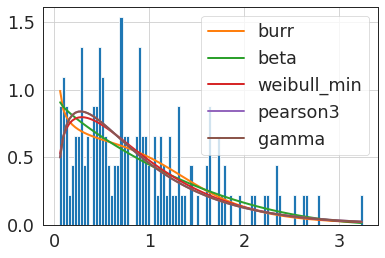

In [ ]:
dis = new_distance["PM2.5"].values
PM2_min=min(dis)
PM2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_P=f.fitted_param[distribution]

2.4610285911742316 2.968268709834093 4.247676907218201


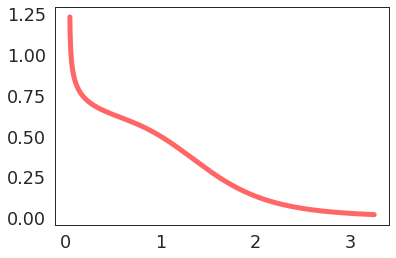

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_PM2_l, threshold_PM2_m, threshold_PM2_h= get_thresholds(dis, param_P, PM2_min, PM2_max,num_var)
print(threshold_PM2_l, threshold_PM2_m, threshold_PM2_h)


             sumsquare_error         aic         bic  kl_div
beta                0.967166  547.739340 -688.644893     inf
weibull_min         0.967999  550.404763 -693.478437     inf
pearson3            0.968404  550.901511 -693.418970     inf
gamma               0.968407  550.895630 -693.418612     inf
invgauss            1.025884  558.448695 -685.231234     inf


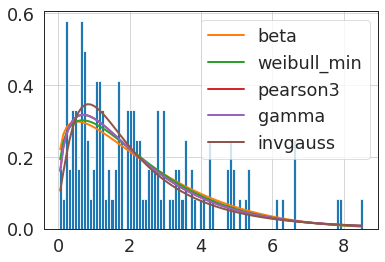

In [ ]:
dis = new_distance["CO2"].values
CO2_min=min(dis)
CO2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_CO2=f.fitted_param[distribution]

6.173649345984174 7.044540793021664 8.496026538084148


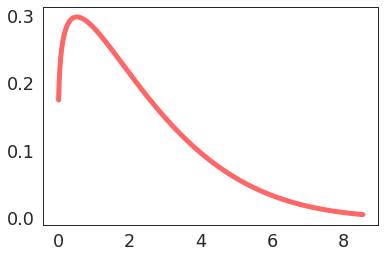

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_CO2_l, threshold_CO2_m, threshold_CO2_h= get_thresholds(dis, param_CO2, CO2_min, CO2_max,num_var)
print(threshold_CO2_l, threshold_CO2_m, threshold_CO2_h)


             sumsquare_error        aic       bic  kl_div
beta              121.730322 -10.290735 -2.047380     inf
weibull_min       122.900966  -0.152207 -5.644160     inf
gamma             124.755091   1.153975 -3.517900     inf
pearson3          124.755099   1.156519 -3.517890     inf
triang            135.636338 -45.899116  8.356818     inf


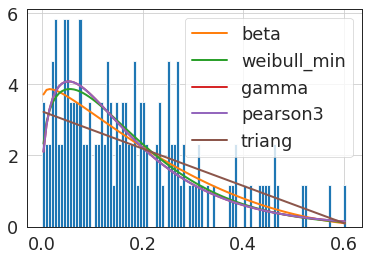

In [ ]:
dis = new_distance["Temp. int."].values
Temp_min=min(dis)
Temp_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_Temp= f.fitted_param[distribution]

0.4626894700655624 0.5134466904517339 0.5871655105364115


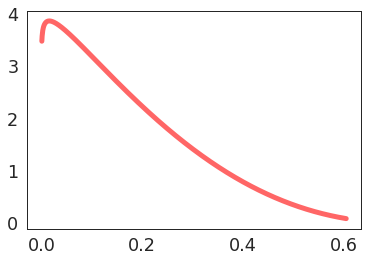

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_Temp_l, threshold_Temp_m, threshold_Temp_h= get_thresholds(dis, param_Temp, Temp_min, Temp_max,num_var)
print(threshold_Temp_l, threshold_Temp_m, threshold_Temp_h)

        sumsquare_error        aic        bic  kl_div
beta         215.129660 -26.618293  78.812076     inf
triang       218.351654 -50.745270  75.967212     inf
burr         221.511056 -19.293102  82.962961     inf
expon        221.782492 -12.099727  73.225205     inf
gamma        223.369031 -13.893413  79.193225     inf


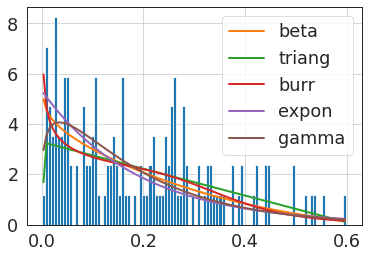

In [ ]:
dis = new_distance["T"].values
T_min=min(dis)
T_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_T=f.fitted_param[distribution]

0.4937160684226881 0.5487737273768581 0.6271710461050785


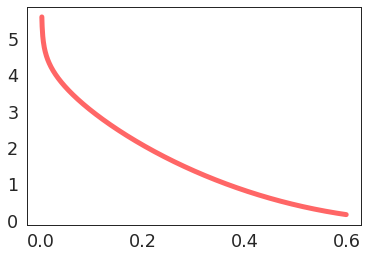

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_T_l, threshold_T_m, threshold_T_h= get_thresholds(dis, param_T, T_min, T_max,num_var)
print(threshold_T_l, threshold_T_m, threshold_T_h)

             sumsquare_error         aic         bic  kl_div
burr                0.832934  531.956075 -709.861891     inf
beta                0.846938  522.677420 -707.494359     inf
triang              0.886639  485.863207 -705.944965     inf
weibull_min         0.897903  525.872483 -704.152415     inf
pearson3            0.904233  528.659007 -703.154886     inf


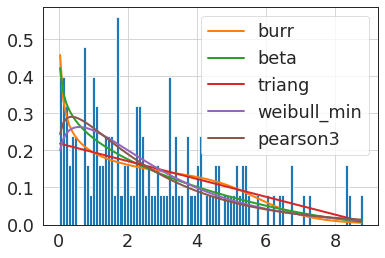

In [ ]:
dis = new_distance["PM10"].values
PM10_min=min(dis)
PM10_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_PM10=f.fitted_param[distribution]

6.591907477913099 7.323314749824396 8.839002108483951


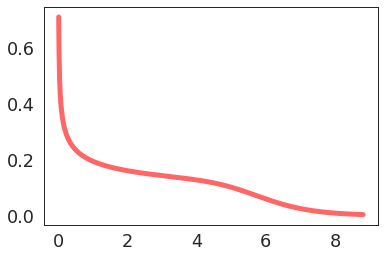

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_PM10_l, threshold_PM10_m, threshold_PM10_h= get_thresholds(dis, param_PM10, PM10_min, PM10_max,num_var)
print(threshold_PM10_l, threshold_PM10_m, threshold_PM10_h)


          sumsquare_error         aic          bic  kl_div
burr             0.047503  845.404611 -1116.572790     inf
beta             0.051269  813.427376 -1105.738252     inf
gamma            0.053702  828.818144 -1104.110833     inf
expon            0.055340  822.999294 -1104.801101     inf
pearson3         0.055884  835.037665 -1098.455107     inf


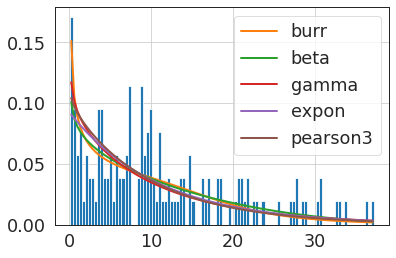

In [ ]:
dis = new_distance["RH"].values
RH_min=min(dis)
RH_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_RH=f.fitted_param[distribution]

29.451431145677386 35.80947517298688 51.79753910130901


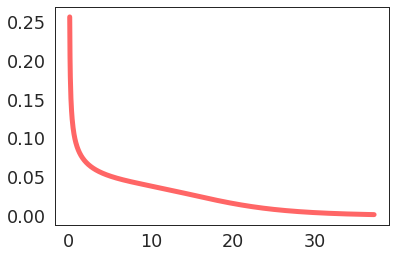

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_RH_l, threshold_RH_m, threshold_RH_h= get_thresholds(dis, param_RH, RH_min, RH_max,num_var)
print(threshold_RH_l, threshold_RH_m, threshold_RH_h)


          sumsquare_error         aic         bic  kl_div
beta             0.130439  714.253715 -973.137166     inf
gamma            0.130871  726.772540 -977.622685     inf
pearson3         0.130872  726.774492 -977.622382     inf
burr             0.134456  738.915022 -968.829836     inf
invgauss         0.136493  735.164610 -971.650773     inf


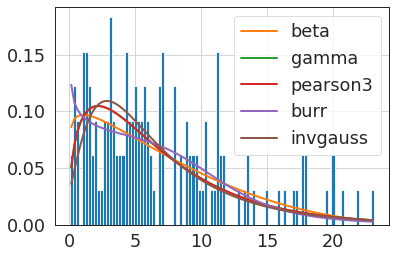

In [ ]:
dis = new_distance["NO2"].values
NO2_min=min(dis)
NO2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_NO2=f.fitted_param[distribution]

18.049916457018206 20.106774134320357 23.18050527006402


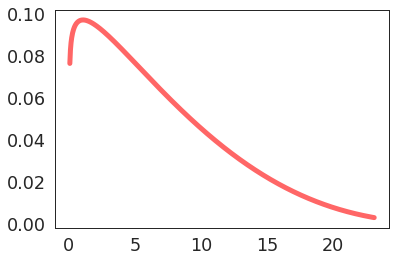

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_NO2_l, threshold_NO2_m, threshold_NO2_h= get_thresholds(dis, param_NO2, NO2_min, NO2_max,num_var)
print(threshold_NO2_l, threshold_NO2_m, threshold_NO2_h)

             sumsquare_error         aic         bic  kl_div
weibull_min         2.401322  445.316676 -564.465227     inf
pearson3            2.403399  445.791869 -564.342454     inf
gamma               2.403404  445.796219 -564.342136     inf
beta                2.434669  439.312282 -557.550979     inf
invgauss            2.487469  454.708909 -559.460237     inf


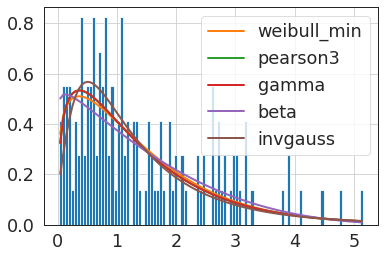

In [ ]:
dis = new_distance["CO"].values
CO_min=min(dis)
CO_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_CO=f.fitted_param[distribution]

3.885832258807461 4.564737399874336 5.860829032820189


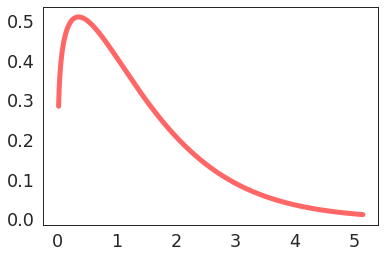

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_CO_l, threshold_CO_m, threshold_CO_h= get_thresholds(dis, param_CO, CO_min, CO_max,num_var)
print(threshold_CO_l, threshold_CO_m, threshold_CO_h)

          sumsquare_error         aic         bic  kl_div
burr             0.510089  590.182450 -779.494192     inf
beta             0.609981  602.839596 -754.098555     inf
gamma            0.612351  603.658903 -758.503777     inf
pearson3         0.613884  599.156897 -758.148801     inf
expon            0.626322  595.579799 -760.256249     inf


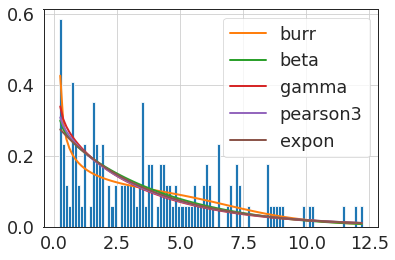

In [ ]:
dis = new_distance["VOC"].values
VOC_min=min(dis)
VOC_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_VOC=f.fitted_param[distribution]

10.365279982197787 12.165415372472026 16.39816615500875


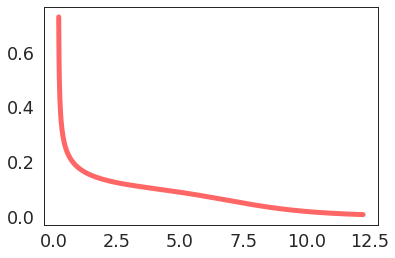

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_VOC_l, threshold_VOC_m, threshold_VOC_h= get_thresholds(dis, param_VOC, VOC_min, VOC_max,num_var)
print(threshold_VOC_l, threshold_VOC_m, threshold_VOC_h)


# Using the thresholds to search anomalies 

In [ ]:
to_show=72
def find_anomalies_thresholds(errors, threshold_low, threshold_med, threshold_high):
  predictions=pd.DataFrame(np.zeros((len(errors), 1)))
  for i in range(len(errors)):
    if((errors.iloc[i] >= threshold_low) &(errors.iloc[i] < threshold_med)):
      predictions.iloc[i]=1
    if((errors.iloc[i] >= threshold_med) &(errors.iloc[i]< threshold_high)):
      predictions.iloc[i]=2
    if(errors.iloc[i] >= threshold_high):
      predictions.iloc[i]=3
  return predictions

data_thresh=df_copy.iloc[-to_show:,:]

Finding anomalies with the burr distribution (O3)

In [ ]:
predictions_O3 = find_anomalies_thresholds(distance['O3'], threshold_O3_l, threshold_O3_m, threshold_O3_h)

data_thresh['Predictions_O3'] = predictions_O3.iloc[-to_show:,:].values
data_thresh['Predictions_O3'].value_counts()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    70
2.0     1
1.0     1
Name: Predictions_O3, dtype: int64

Finding anomalies with the burr distribution (PM2.5)

In [ ]:
predictions_PM2 = find_anomalies_thresholds(distance['PM2.5'], threshold_PM2_l, threshold_PM2_m, threshold_PM2_h)

data_thresh['Predictions_PM2.5'] = predictions_PM2.iloc[-to_show:,:].values
data_thresh['Predictions_PM2.5'].value_counts()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    69
1.0     2
3.0     1
Name: Predictions_PM2.5, dtype: int64

Finding anomalies with the burr distribution (CO2)

In [ ]:
predictions_CO2 = find_anomalies_thresholds(distance['CO2'], threshold_CO2_l, threshold_CO2_m, threshold_CO2_h)

data_thresh['Predictions_CO2'] = predictions_CO2.iloc[-to_show:,:].values
data_thresh['Predictions_CO2'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    68
1.0     2
2.0     1
3.0     1
Name: Predictions_CO2, dtype: int64

Finding anomalies with the beta distribution (Temp. int.)

In [ ]:
predictions_Temp = find_anomalies_thresholds(distance['Temp. int.'], threshold_Temp_l, threshold_Temp_m, threshold_Temp_h)

data_thresh['Predictions_Temp. int.'] = predictions_Temp.iloc[-to_show:,:].values
data_thresh['Predictions_Temp. int.'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    69
2.0     2
1.0     1
Name: Predictions_Temp. int., dtype: int64

Finding anomalies with the burr distribution (T)


In [ ]:
predictions_T = find_anomalies_thresholds(distance['T'], threshold_T_l, threshold_T_m, threshold_T_h)

data_thresh['Predictions_T'] = predictions_T.iloc[-to_show:,:].values
data_thresh['Predictions_T'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    70
2.0     1
1.0     1
Name: Predictions_T, dtype: int64

Finding anomalies with the burr distribution (PM10)

In [ ]:
predictions_PM10 = find_anomalies_thresholds(distance['PM10'], threshold_PM10_l, threshold_PM10_m, threshold_PM10_h)

data_thresh['Predictions_PM10'] = predictions_PM10.iloc[-to_show:,:].values
data_thresh['Predictions_PM10'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    67
1.0     2
2.0     2
3.0     1
Name: Predictions_PM10, dtype: int64

Finding anomalies with the burr distribution (RH)

In [ ]:
predictions_RH = find_anomalies_thresholds(distance['RH'], threshold_RH_l, threshold_RH_m, threshold_RH_h)

data_thresh['Predictions_RH'] = predictions_RH.iloc[-to_show:,:].values
data_thresh['Predictions_RH'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    71
1.0     1
Name: Predictions_RH, dtype: int64

Finding anomalies with the burr distribution (NO2)

In [ ]:
predictions_NO2 = find_anomalies_thresholds(distance['NO2'], threshold_NO2_l, threshold_NO2_m, threshold_NO2_h)

data_thresh['Predictions_NO2'] = predictions_NO2.iloc[-to_show:,:].values
data_thresh['Predictions_NO2'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    68
1.0     2
2.0     2
Name: Predictions_NO2, dtype: int64

Finding anomalies with the burr distribution (CO)

In [ ]:
predictions_CO = find_anomalies_thresholds(distance['CO'], threshold_CO_l, threshold_CO_m, threshold_CO_h)

data_thresh['Predictions_CO'] = predictions_CO.iloc[-to_show:,:].values
data_thresh['Predictions_CO'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    70
1.0     1
2.0     1
Name: Predictions_CO, dtype: int64

Finding anomalies with the beta distribution (VOC)

In [ ]:
predictions_VOC = find_anomalies_thresholds(distance['VOC'], threshold_VOC_l, threshold_VOC_m, threshold_VOC_h)

data_thresh['Predictions_VOC'] = predictions_VOC.iloc[-to_show:,:].values
data_thresh['Predictions_VOC'].value_counts()
display(data_thresh[-50:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions_O3,Predictions_PM2.5,Predictions_CO2,Predictions_Temp. int.,Predictions_T,Predictions_PM10,Predictions_RH,Predictions_NO2,Predictions_CO,Predictions_VOC
Dates,,,,,,,,,,,,,,,,,,,,
2021-10-21 02,404.172747,14.978541,463.022532,27.266652,14.845601,18.341202,981.137339,223.212446,245.706009,354.824034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-22 02,441.784270,12.742697,474.108989,29.163337,16.727416,17.426966,925.458427,250.313483,242.134831,356.952809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-23 02,297.971953,15.548004,452.476807,27.355642,15.665912,23.149946,784.892125,153.966559,214.839266,310.135922,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-24 02,76.783172,2.124056,410.094930,27.890410,16.478749,4.062567,568.887810,18.880259,187.343042,238.579288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-25 02,59.653148,1.442903,403.967983,26.356051,14.778762,3.648879,520.229456,14.147279,178.033084,227.529349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-26 02,127.273504,5.598291,414.255342,26.055502,14.398825,9.934829,626.633547,44.314103,192.152778,256.642094,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-10-27 02,78.398058,4.595469,410.670982,27.758501,16.237325,9.247033,496.581446,16.165049,182.203883,239.475728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-28 02,107.459052,11.707974,415.299569,27.511778,16.183836,14.504310,494.796336,22.761853,185.754310,250.737069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-29 02,381.626078,18.598060,449.636853,24.916099,12.884698,24.997845,717.329741,172.207974,205.859914,337.737069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create a table with results and differenced data

In [ ]:
data_diff=data_thresh.copy()
for col in df_copy.columns:
  data_diff[col]=df_e[col].iloc[-to_show:]

# Showing the anomalies (differenced values) found with the euclidian distance with graphs

In [ ]:
show_data_diff=data_diff.iloc[-to_show:,:]
day_before= df_e.iloc[-(to_show*2):-to_show,:]
x_ticks = np.arange(0, to_show, 8)
x_ticks_before= np.arange(0, to_show, 8)

Using this differencing out[i] = arr[i+1] – arr[i]

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

def show_anomalies_euclidian(anomalies_l, anomalies_m, anomalies_h, col):
  # Plot
  fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', dpi=120, figsize=(12,3))
  plt.setp(axes, xticks=x_ticks)
  for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      ax.bar(show_data_diff.index, 0)
      data_temp = show_data_diff[(data_diff['Predictions_'+col] == 0)][col]
      ax.bar(data_temp.index, data_temp ,color='teal',alpha=0.7, linewidth=1)
      data_expeted= var_fit_df[col].iloc[-to_show:]
      ax.set_xticks(x_ticks)    
      # x axis value list.
      x_number_list_l = list(anomalies_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_l[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', alpha=0.7, linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_m[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange', alpha=0.7, linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_h[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red',alpha=0.7, linewidth=1)
      #lag rectangle
      left, bottom, width, height = (-0.5, 0, 1*selected_lag_eucl, int(max(show_data_diff[col]+2)))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))
      ax.bar(data_expeted.index, data_expeted ,fill = False, edgecolor = 'black', linewidth=0.5)


      # Decorations
      ax.set_title(col)
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)
    else:
      data_before = day_before[col]
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      ax.set_xticks(x_ticks_before)
      # Decorations
      ax.set_title(col+' days before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)

  plt.tight_layout();


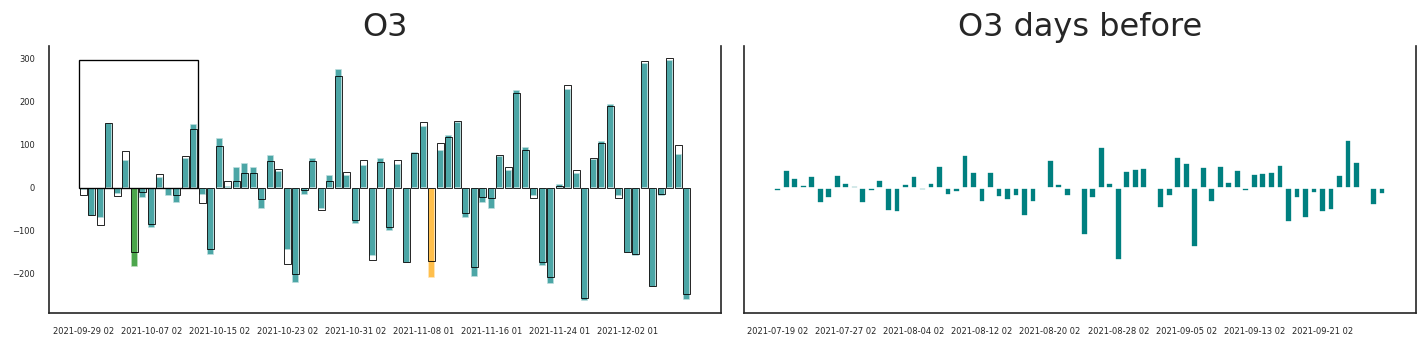

In [ ]:
anomalies_O3_l= show_data_diff[(data_diff['Predictions_O3'] == 1)]
anomalies_O3_m= show_data_diff[(data_diff['Predictions_O3'] == 2)]
anomalies_O3_h= show_data_diff[(data_diff['Predictions_O3'] == 3)]

show_anomalies_euclidian(anomalies_O3_l, anomalies_O3_m, anomalies_O3_h, 'O3')

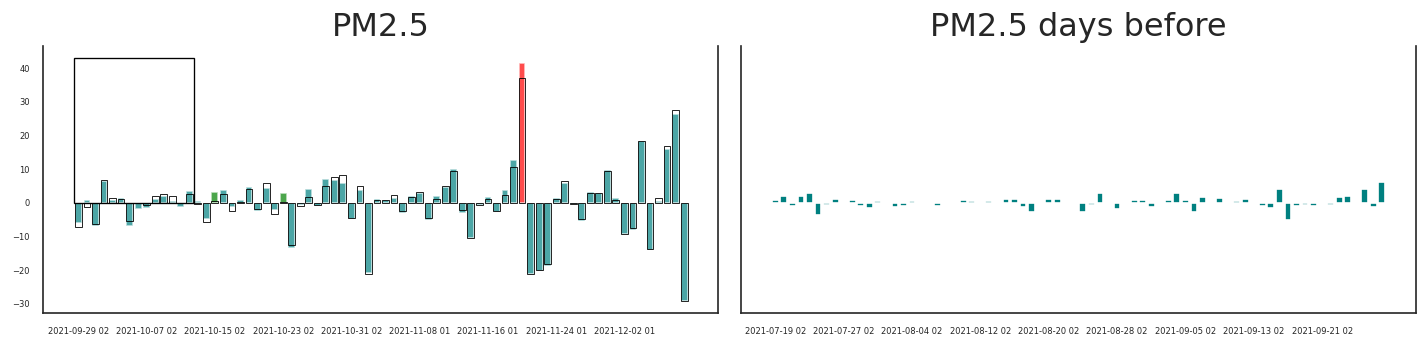

In [ ]:
anomalies_PM2_l= show_data_diff[(data_diff['Predictions_PM2.5'] == 1)]
anomalies_PM2_m= show_data_diff[(data_diff['Predictions_PM2.5'] == 2)]
anomalies_PM2_h= show_data_diff[(data_diff['Predictions_PM2.5'] == 3)]

show_anomalies_euclidian(anomalies_PM2_l, anomalies_PM2_m, anomalies_PM2_h, 'PM2.5')

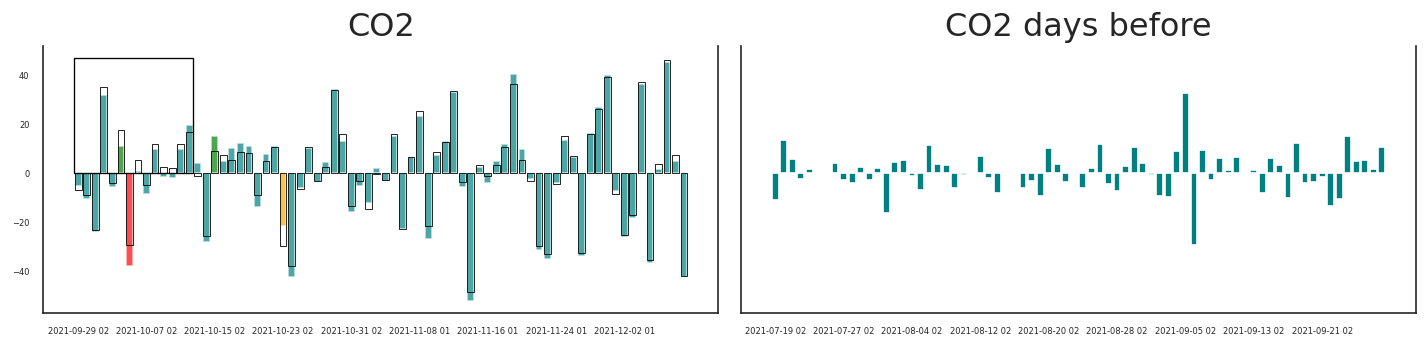

In [ ]:
anomalies_CO2_l= show_data_diff[(data_diff['Predictions_CO2'] == 1)]
anomalies_CO2_m= show_data_diff[(data_diff['Predictions_CO2'] == 2)]
anomalies_CO2_h= show_data_diff[(data_diff['Predictions_CO2'] == 3)]

show_anomalies_euclidian(anomalies_CO2_l, anomalies_CO2_m, anomalies_CO2_h, 'CO2')

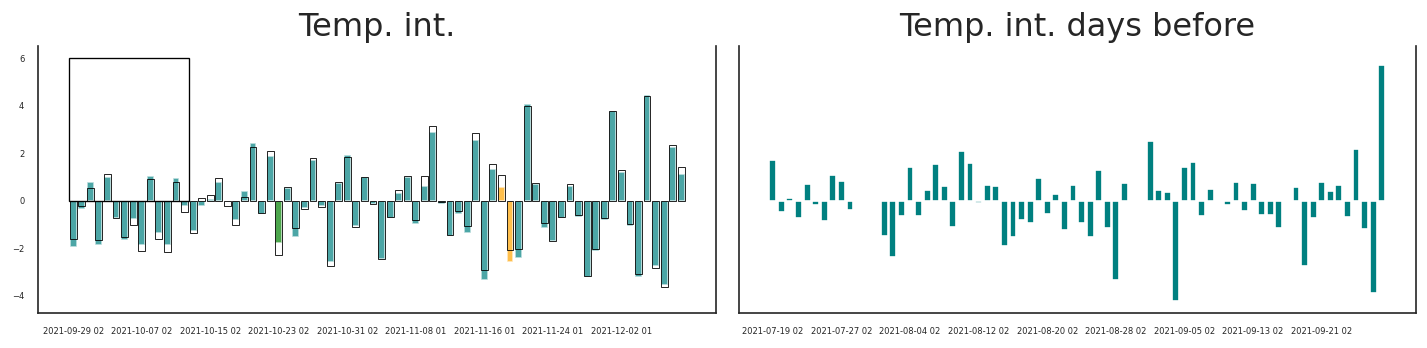

In [ ]:
anomalies_Temp_l= show_data_diff[(data_diff['Predictions_Temp. int.'] == 1)]
anomalies_Temp_m= show_data_diff[(data_diff['Predictions_Temp. int.'] == 2)]
anomalies_Temp_h= show_data_diff[(data_diff['Predictions_Temp. int.'] == 3)]


show_anomalies_euclidian(anomalies_Temp_l, anomalies_Temp_m, anomalies_Temp_h, 'Temp. int.')

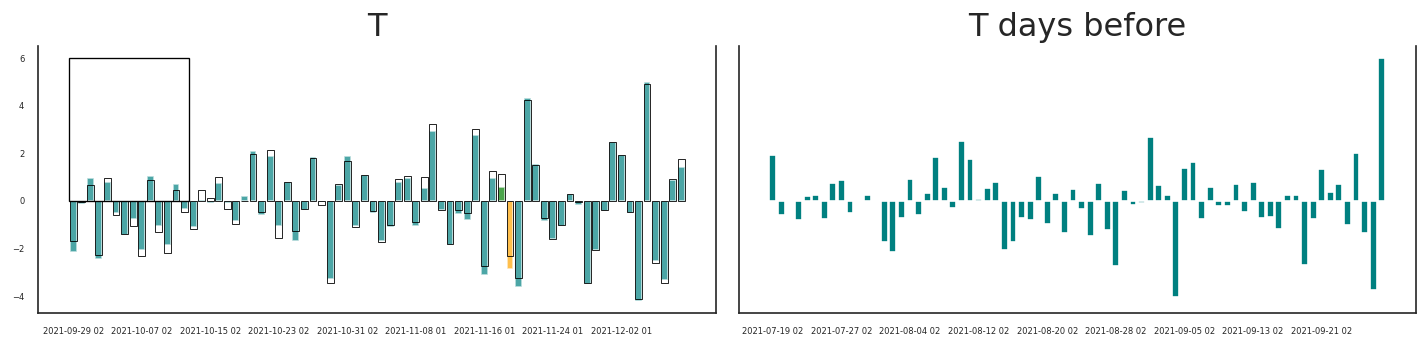

In [ ]:
anomalies_T_l= show_data_diff[(data_diff['Predictions_T'] == 1)]
anomalies_T_m= show_data_diff[(data_diff['Predictions_T'] == 2)]
anomalies_T_h= show_data_diff[(data_diff['Predictions_T'] == 3)]

show_anomalies_euclidian(anomalies_T_l, anomalies_T_m, anomalies_T_h, 'T')

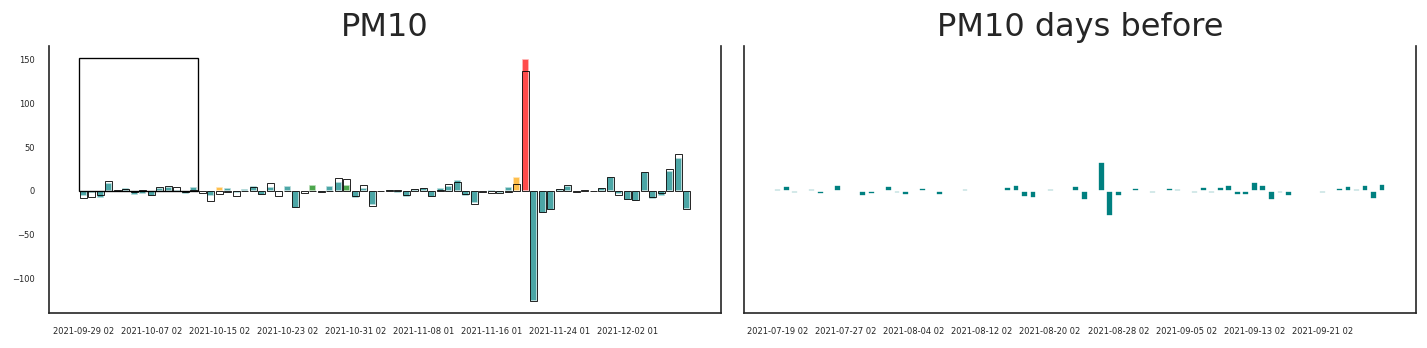

In [ ]:
anomalies_PM10_l= show_data_diff[(data_diff['Predictions_PM10'] == 1)]
anomalies_PM10_m= show_data_diff[(data_diff['Predictions_PM10'] == 2)]
anomalies_PM10_h= show_data_diff[(data_diff['Predictions_PM10'] == 3)]

show_anomalies_euclidian(anomalies_PM10_l, anomalies_PM10_m, anomalies_PM10_h, 'PM10')

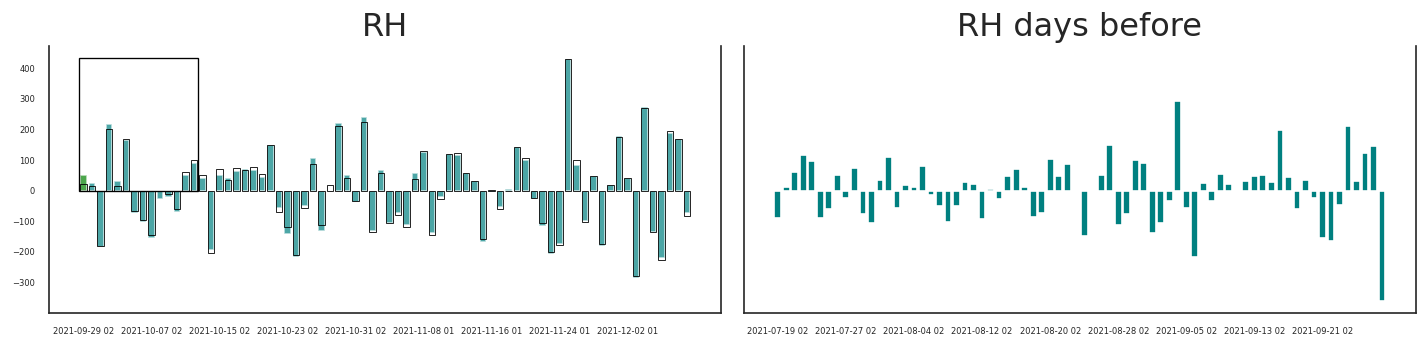

In [ ]:
anomalies_RH_l= show_data_diff[(data_diff['Predictions_RH'] == 1)]
anomalies_RH_m= show_data_diff[(data_diff['Predictions_RH'] == 2)]
anomalies_RH_h= show_data_diff[(data_diff['Predictions_RH'] == 3)]

show_anomalies_euclidian(anomalies_RH_l, anomalies_RH_m, anomalies_RH_h, 'RH')

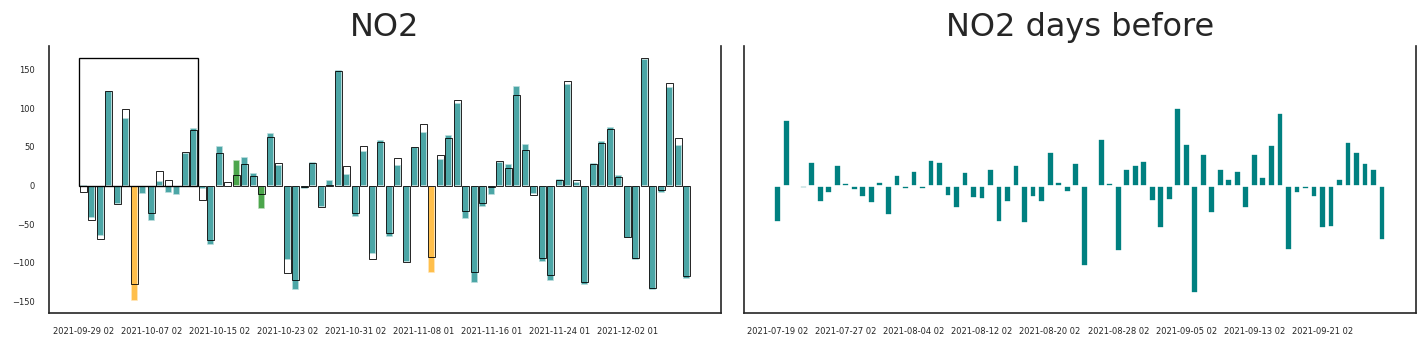

In [ ]:
anomalies_NO2_l= show_data_diff[(data_diff['Predictions_NO2'] == 1)]
anomalies_NO2_m= show_data_diff[(data_diff['Predictions_NO2'] == 2)]
anomalies_NO2_h= show_data_diff[(data_diff['Predictions_NO2'] == 3)]

show_anomalies_euclidian(anomalies_NO2_l, anomalies_NO2_m, anomalies_NO2_h, 'NO2')

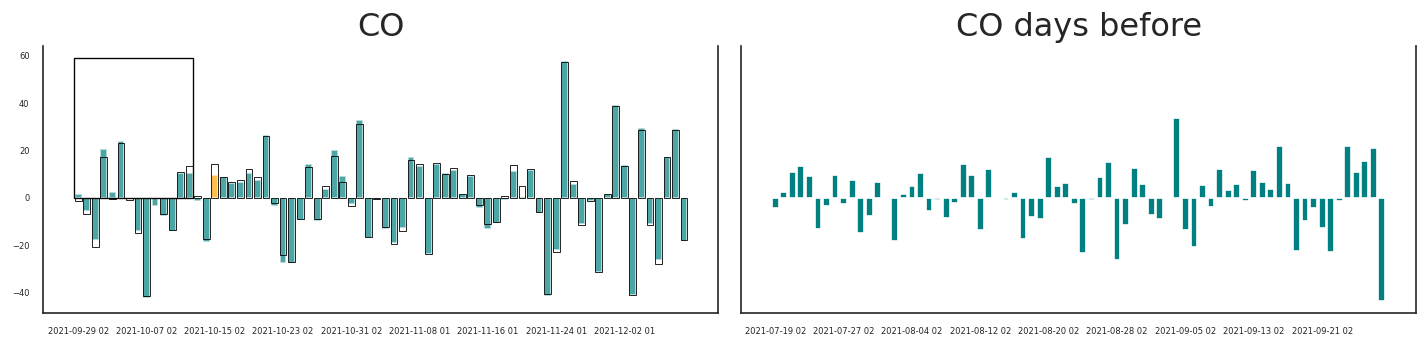

In [ ]:
anomalies_CO_l= show_data_diff[(data_diff['Predictions_CO'] == 1)]
anomalies_CO_m= show_data_diff[(data_diff['Predictions_CO'] == 2)]
anomalies_CO_h= show_data_diff[(data_diff['Predictions_CO'] == 3)]

show_anomalies_euclidian(anomalies_CO_l, anomalies_CO_m, anomalies_CO_h, 'CO')

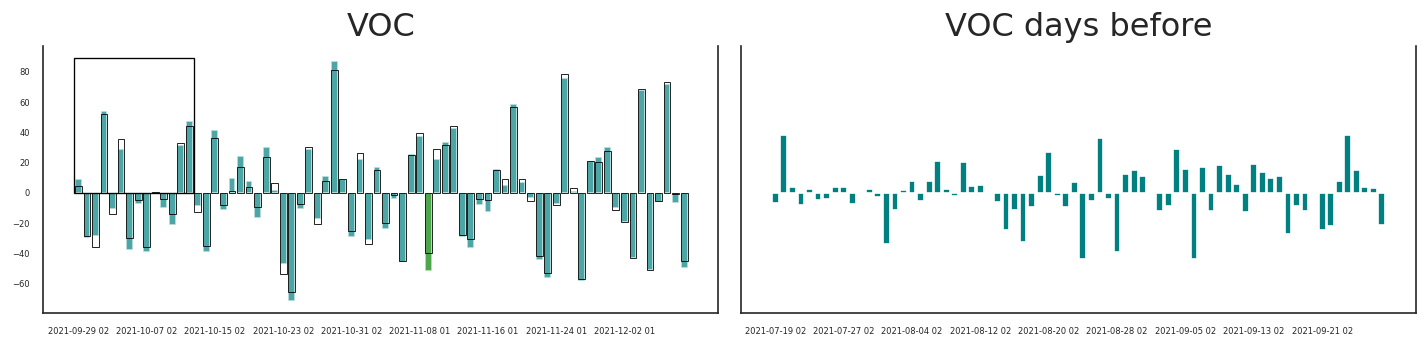

In [ ]:
anomalies_VOC_l= show_data_diff[(data_diff['Predictions_VOC'] == 1)]
anomalies_VOC_m= show_data_diff[(data_diff['Predictions_VOC'] == 2)]
anomalies_VOC_h= show_data_diff[(data_diff['Predictions_VOC'] == 3)]

show_anomalies_euclidian(anomalies_VOC_l, anomalies_VOC_m, anomalies_VOC_h, 'VOC')

# Showing the anomalies found with the euclidian distance with graphs

Reverse differencing the predicted values

In [ ]:
diff_range=6
many_times=to_show/diff_range
difference = pd.DataFrame(index=df_copy.index[-to_show:], columns=df_copy.columns)
for i in range(int(many_times)):
  if(i==many_times-1):
    temp = pd.DataFrame(index=df_copy.index[-diff_range-1:], columns=df_copy.columns)
  else:
    temp = pd.DataFrame(index=df_copy.index[-to_show-1+diff_range*i:-to_show+diff_range*(i+1)], columns=df_copy.columns)
  for col in df_copy.columns:
    if(i==many_times-1):
      x, x_diff = df_copy[col].iloc[-to_show-1+diff_range*i:-to_show+diff_range*i], var_fit_df[-diff_range:][col]
    else:
      x, x_diff = df_copy[col].iloc[-to_show-1+diff_range*i:-to_show+diff_range*i], var_fit_df[-to_show+diff_range*i:-to_show+diff_range*(i+1)][col]
    temp[col] = np.r_[x, x_diff].cumsum()
  #dopo il revert differencing i valori sono 7, non 6
  temp=temp.iloc[-diff_range:]
  if(i==many_times-1):
    difference.iloc[-diff_range:]=temp
  else:
    difference.iloc[-to_show+diff_range*i:-to_show+diff_range*(i+1)]=temp

In [ ]:
show_data_thresh=data_thresh.iloc[-to_show:,:]
day_before= df_copy.iloc[-(to_show*2):-to_show,:]
#lines= np.arange(0, to_show, diff_range)
x_ticks = np.arange(0, to_show, 8)
x_ticks_before= np.arange(0, to_show, 8)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

def show_anomalies_euclidian(anomalies_l, anomalies_m, anomalies_h, col):
  # Plot
  fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', dpi=120, figsize=(12,3))
  plt.setp(axes, xticks=x_ticks)
  for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      ax.bar(show_data_thresh.index, 0)
      data_temp = show_data_thresh[(data_thresh['Predictions_'+col] == 0)][col]
      ax.bar(data_temp.index, data_temp ,color='teal', alpha=1, linewidth=1)
      #ax.bar(difference[col].index, difference[col] ,color='black', alpha=0.5, linewidth=1)
      ax.set_xticks(x_ticks)    
      # x axis value list.
      x_number_list_l = list(anomalies_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_l[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', alpha=1, linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_m[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange', alpha=1, linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_h[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red', alpha=1, linewidth=1)
      #lag rectangle
      left, bottom, width, height = (-0.5, 0, 1*selected_lag_eucl, int(max(show_data_thresh[col]+2)))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))
      #lines
      #for j in range(len(lines)):
       # ax.axvline(lines[j]	, color='black', alpha=0.3)

      # Decorations
      ax.set_title(col)
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)
    else:
      data_before = day_before[col]
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      ax.set_xticks(x_ticks_before)
      # Decorations
      ax.set_title(col+' days before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)

  plt.tight_layout();


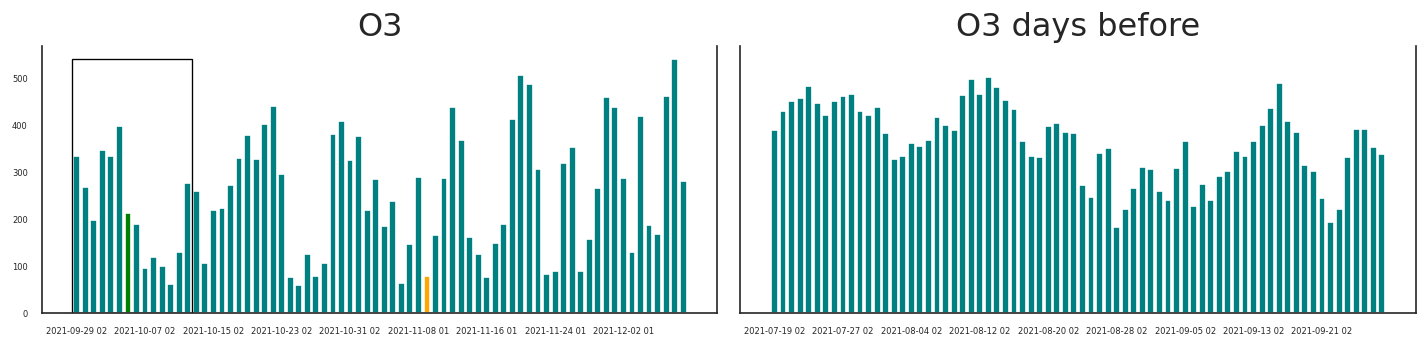

In [ ]:
anomalies_O3_l= show_data_thresh[(data_thresh['Predictions_O3'] == 1)]
anomalies_O3_m= show_data_thresh[(data_thresh['Predictions_O3'] == 2)]
anomalies_O3_h= show_data_thresh[(data_thresh['Predictions_O3'] == 3)]

show_anomalies_euclidian(anomalies_O3_l, anomalies_O3_m, anomalies_O3_h, 'O3')

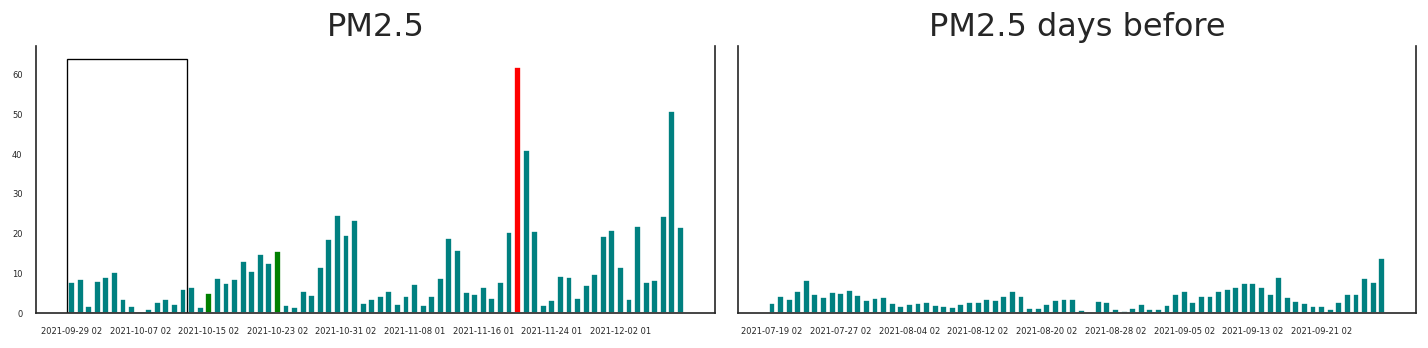

In [ ]:
anomalies_PM2_l= show_data_thresh[(data_thresh['Predictions_PM2.5'] == 1)]
anomalies_PM2_m= show_data_thresh[(data_thresh['Predictions_PM2.5'] == 2)]
anomalies_PM2_h= show_data_thresh[(data_thresh['Predictions_PM2.5'] == 3)]

show_anomalies_euclidian(anomalies_PM2_l, anomalies_PM2_m, anomalies_PM2_h, 'PM2.5')

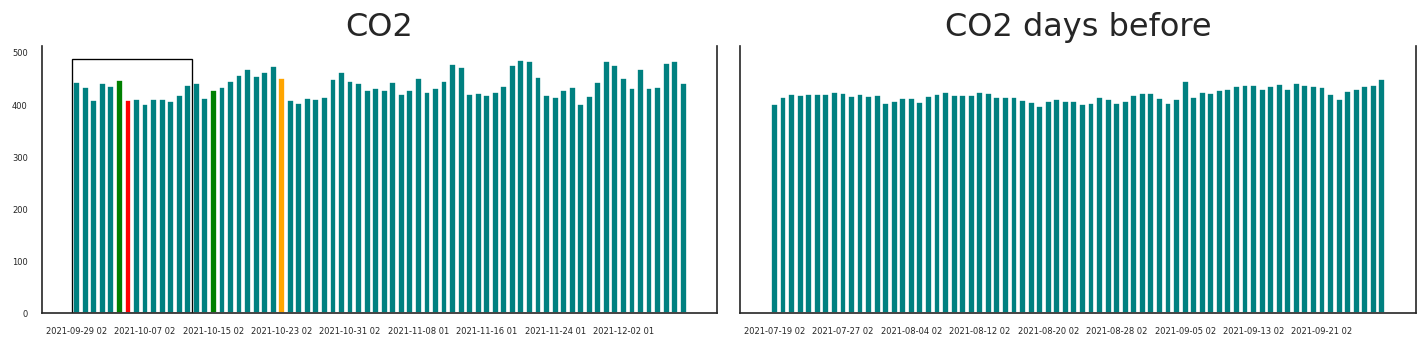

In [ ]:
anomalies_CO2_l= show_data_thresh[(data_thresh['Predictions_CO2'] == 1)]
anomalies_CO2_m= show_data_thresh[(data_thresh['Predictions_CO2'] == 2)]
anomalies_CO2_h= show_data_thresh[(data_thresh['Predictions_CO2'] == 3)]

show_anomalies_euclidian(anomalies_CO2_l, anomalies_CO2_m, anomalies_CO2_h, 'CO2')

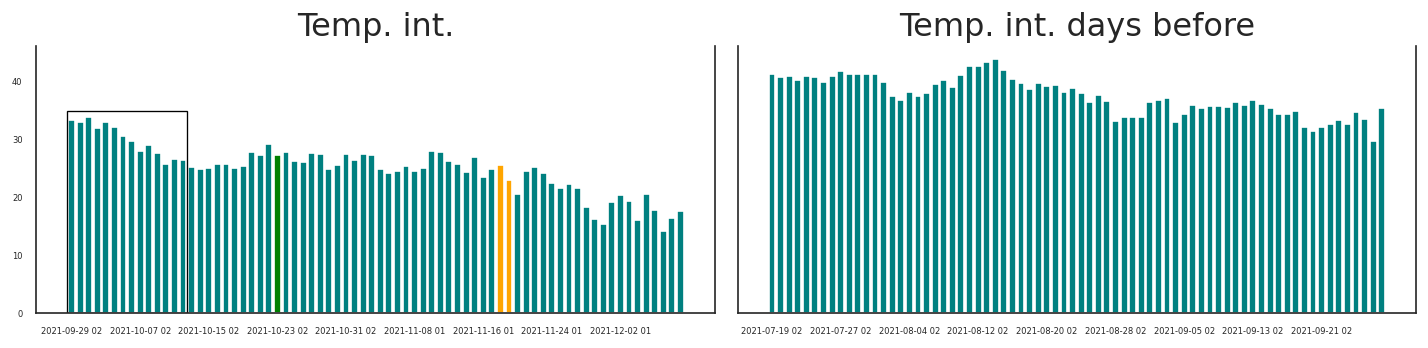

In [ ]:
anomalies_Temp_l= show_data_thresh[(data_thresh['Predictions_Temp. int.'] == 1)]
anomalies_Temp_m= show_data_thresh[(data_thresh['Predictions_Temp. int.'] == 2)]
anomalies_Temp_h= show_data_thresh[(data_thresh['Predictions_Temp. int.'] == 3)]


show_anomalies_euclidian(anomalies_Temp_l, anomalies_Temp_m, anomalies_Temp_h, 'Temp. int.')

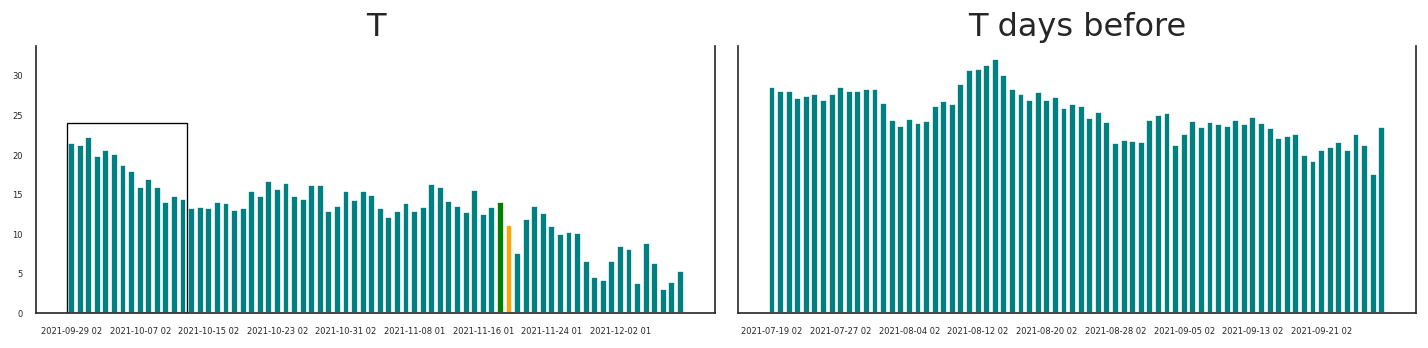

In [ ]:
anomalies_T_l= show_data_thresh[(data_thresh['Predictions_T'] == 1)]
anomalies_T_m= show_data_thresh[(data_thresh['Predictions_T'] == 2)]
anomalies_T_h= show_data_thresh[(data_thresh['Predictions_T'] == 3)]

show_anomalies_euclidian(anomalies_T_l, anomalies_T_m, anomalies_T_h, 'T')

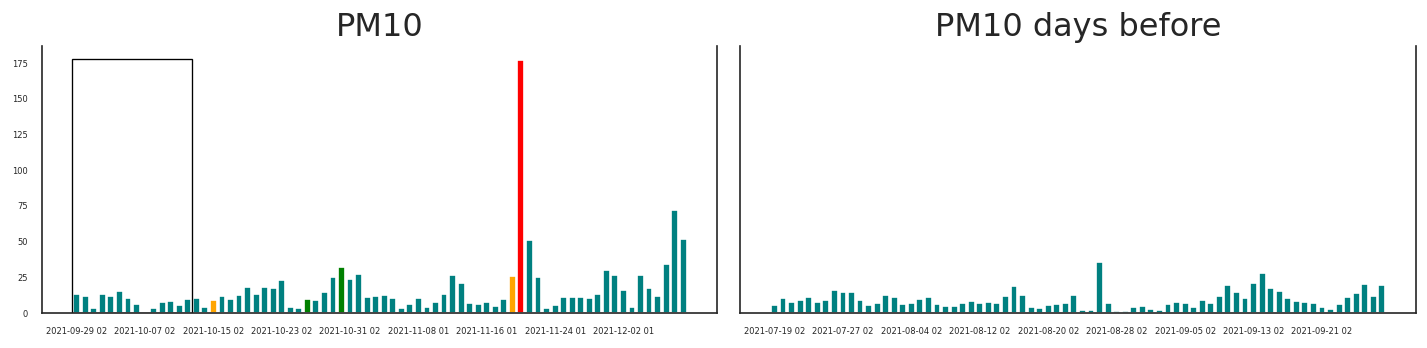

In [ ]:
anomalies_PM10_l= show_data_thresh[(data_thresh['Predictions_PM10'] == 1)]
anomalies_PM10_m= show_data_thresh[(data_thresh['Predictions_PM10'] == 2)]
anomalies_PM10_h= show_data_thresh[(data_thresh['Predictions_PM10'] == 3)]

show_anomalies_euclidian(anomalies_PM10_l, anomalies_PM10_m, anomalies_PM10_h, 'PM10')

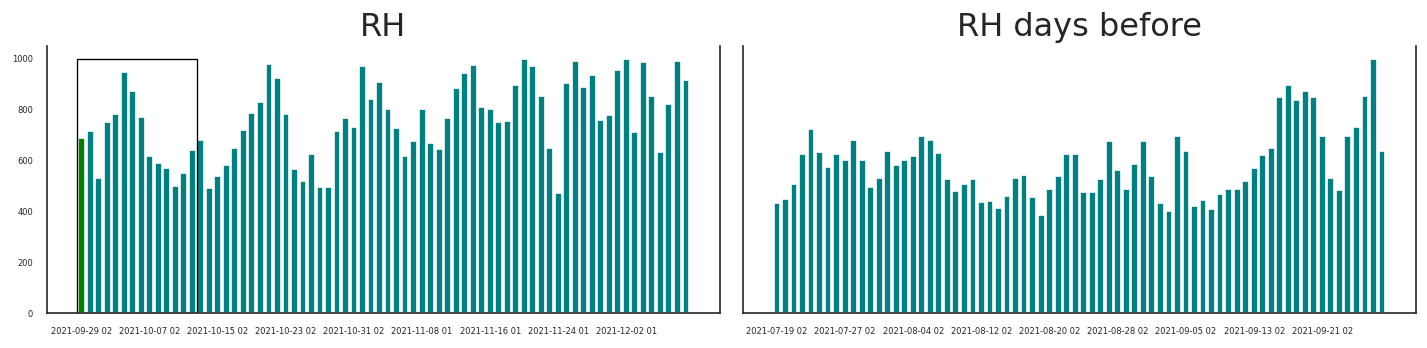

In [ ]:
anomalies_RH_l= show_data_thresh[(data_thresh['Predictions_RH'] == 1)]
anomalies_RH_m= show_data_thresh[(data_thresh['Predictions_RH'] == 2)]
anomalies_RH_h= show_data_thresh[(data_thresh['Predictions_RH'] == 3)]

show_anomalies_euclidian(anomalies_RH_l, anomalies_RH_m, anomalies_RH_h, 'RH')

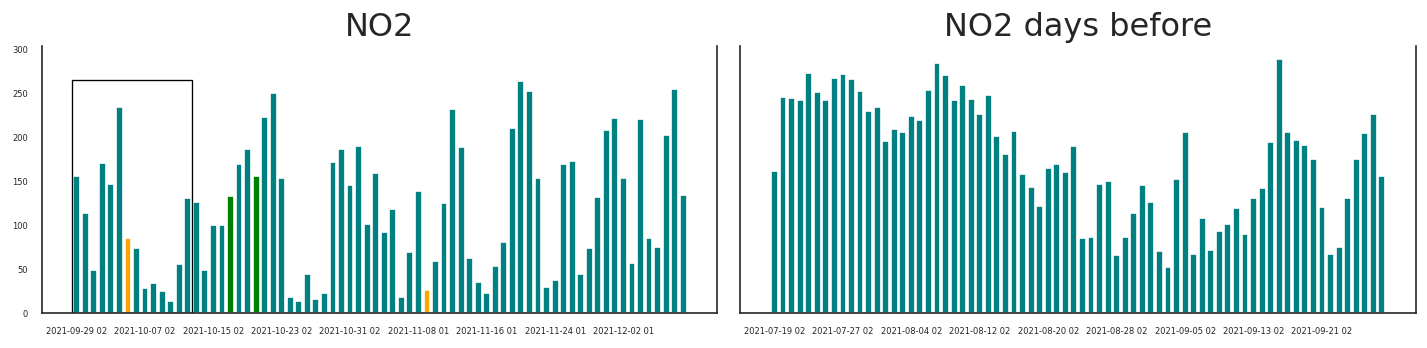

In [ ]:
anomalies_NO2_l= show_data_thresh[(data_thresh['Predictions_NO2'] == 1)]
anomalies_NO2_m= show_data_thresh[(data_thresh['Predictions_NO2'] == 2)]
anomalies_NO2_h= show_data_thresh[(data_thresh['Predictions_NO2'] == 3)]

show_anomalies_euclidian(anomalies_NO2_l, anomalies_NO2_m, anomalies_NO2_h, 'NO2')

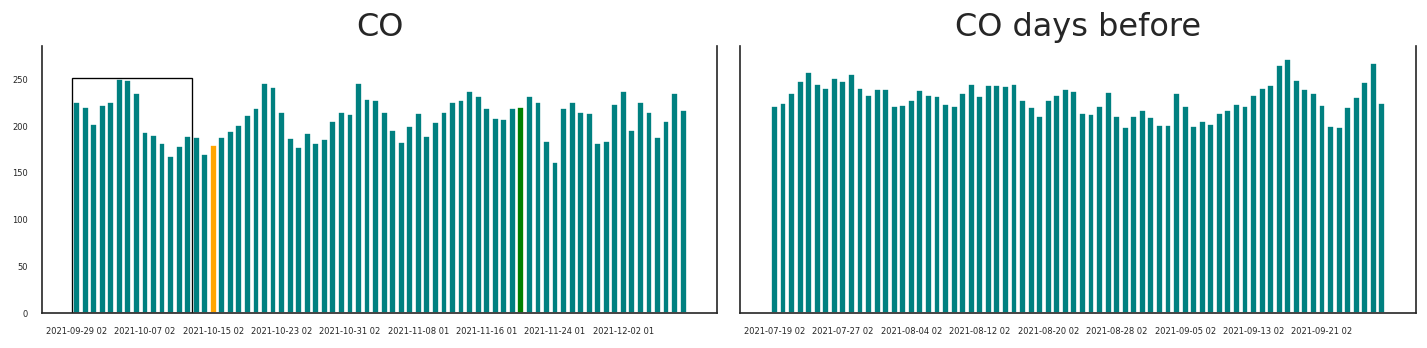

In [ ]:
anomalies_CO_l= show_data_thresh[(data_thresh['Predictions_CO'] == 1)]
anomalies_CO_m= show_data_thresh[(data_thresh['Predictions_CO'] == 2)]
anomalies_CO_h= show_data_thresh[(data_thresh['Predictions_CO'] == 3)]

show_anomalies_euclidian(anomalies_CO_l, anomalies_CO_m, anomalies_CO_h, 'CO')

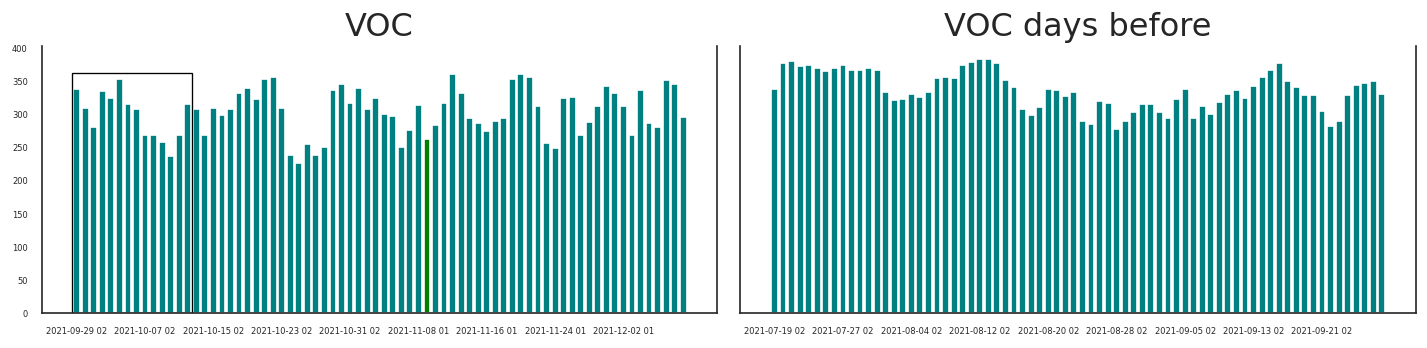

In [ ]:
anomalies_VOC_l= show_data_thresh[(data_thresh['Predictions_VOC'] == 1)]
anomalies_VOC_m= show_data_thresh[(data_thresh['Predictions_VOC'] == 2)]
anomalies_VOC_h= show_data_thresh[(data_thresh['Predictions_VOC'] == 3)]

show_anomalies_euclidian(anomalies_VOC_l, anomalies_VOC_m, anomalies_VOC_h, 'VOC')

# Forecast all

Splitting the series into train and testing data (to_predict= how many values are going to be predicted, forecast_interval= how often the forecast will happen)

to_predict must be a multiple of forecast_interval

In [ ]:
to_predict=24
forecast_interval = 2
df_train, df_test = df_copy[0:-to_predict].copy(), df_copy[-to_predict:].copy()
df_train_inputs=df_copy.copy()

# Check size
print(df_train.shape)  
print(df_test.shape)  

(140, 10)
(24, 10)


Check stationarity with all values and only with the starting values

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results_end = {
    col: test_stationarity(df_train, col)
    for col in df_train.columns
}
display(adf_test_results_end)


{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Non-Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Non-Stationary',
 'RH': 'Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Non-Stationary'}

Use the differencing only on the variables that need it 

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in ['T', 'Temp. int.', 'VOC', 'O3', 'PM2.5']:
    df_train[col] = differencing(df_train, col, 1)
#anche gli input devono essere post differencing se train viene differenziato e usato nel modello
for col in ['T', 'Temp. int.', 'VOC', 'O3', 'PM2.5']:
    df_train_inputs[col] = differencing(df_train_inputs, col, 1)

In [ ]:
from statsmodels.tsa.api import VAR

#con il vento max_lag diverso qui (12 troppo alto)
max_lag=8
model_lag = VAR(df_train.astype(float))
lag_results_for = model_lag.select_order(max_lag)
selected_lag_for = lag_results_for.aic
selected_lag_for=2
print(selected_lag_for)
df_inputs=df_train_inputs[-to_predict-selected_lag_for:-forecast_interval].copy()


2


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
res_fc=pd.DataFrame(index=df_copy.index[-to_predict:], columns=df_copy.columns)
how_many_times=to_predict/forecast_interval
allvalues=[]
model=VAR(df_train.astype(float))
model_fitted = model.fit(selected_lag_for)
var_summaryfor=str(model_fitted.summary())
print(var_summaryfor[0:624])
for i in range(int(how_many_times)):
  if(i==how_many_times-1):
    forecast_input = df_inputs.iloc[-selected_lag_for:].values
  else:
    forecast_input = df_inputs.iloc[(i)*forecast_interval:(i)*forecast_interval+selected_lag_for].values
  fc = model_fitted.forecast(y=forecast_input, steps=forecast_interval)
  if(i==how_many_times-1):
    temp = pd.DataFrame(fc, index=df_copy.index[-forecast_interval:], columns=df_copy.columns)
    diff= pd.DataFrame( index=df_copy.index[-forecast_interval-1:], columns=['T','Temp. int.'])
  else:
    temp = pd.DataFrame(fc, index=df_copy.index[-to_predict+i*forecast_interval:-to_predict+(i+1)*forecast_interval], columns=df_copy.columns)
    diff = pd.DataFrame(index=df_copy.index[-to_predict+i*forecast_interval-1:-to_predict+(i+1)*forecast_interval], columns=['T','Temp. int.'])
  for col in ['T', 'Temp. int.', 'VOC', 'O3', 'PM2.5']:
    x, x_diff = df_copy[col].iloc[-to_predict+i*forecast_interval-1:-to_predict+i*forecast_interval], temp[col]
    diff[col] = np.r_[x, x_diff].cumsum()
  #dopo il revert differencing i valori sono 7, non 6
  diff=diff.iloc[-forecast_interval:]
  for col in ['T', 'Temp. int.', 'VOC', 'O3', 'PM2.5']:
    temp[col]=diff[col]
  res_fc.iloc[i*forecast_interval:(i+1)*forecast_interval]=temp
display(res_fc)
  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Jan, 2022
Time:                     10:52:24
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    39.6740
Nobs:                     138.000    HQIC:                   37.0297
Log likelihood:          -4178.28    FPE:                2.02284e+15
AIC:                      35.2195    Det(Omega_mle):     4.90660e+14
--------------------------------------------------------------------



,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-11-16 01,124.018,4.44751,422.729,26.3598,14.7268,7.08882,736.083,16.3013,213.661,280.638
2021-11-17 01,111.296,6.53403,430.236,24.6078,12.9311,9.97892,696.008,39.7639,198.803,281.737
2021-11-18 01,148.347,7.30925,430.913,25.1393,13.6582,9.21762,721.373,56.3821,203.348,294.811
2021-11-19 01,149.038,7.76167,434.938,24.4905,13.0178,10.2227,687.151,67.594,198.232,298.79
2021-11-20 01,309.508,18.2856,467.803,23.2129,11.4933,21.9383,846.427,144.676,206.399,321.134
2021-11-21 01,255.366,15.4495,452.122,24.0205,12.4478,16.3628,830.284,112.55,211.705,308.696
2021-11-22 01,404.177,36.5083,476.901,19.0191,6.55149,31.9274,1288.35,238.306,260.932,365.745
2021-11-23 01,198.917,24.5084,447.813,19.8953,7.64121,15.2737,1072.23,114.298,237.32,300.853
2021-11-24 01,37.4534,0.506323,402.119,23.4089,11.9979,0.853826,592.138,0.912554,182.426,242.333


In [ ]:
fc_index=res_fc.index
for_index=[]
for i in range(len(fc_index)):
  if(i%forecast_interval==0):
    for_index.append(fc_index[i])

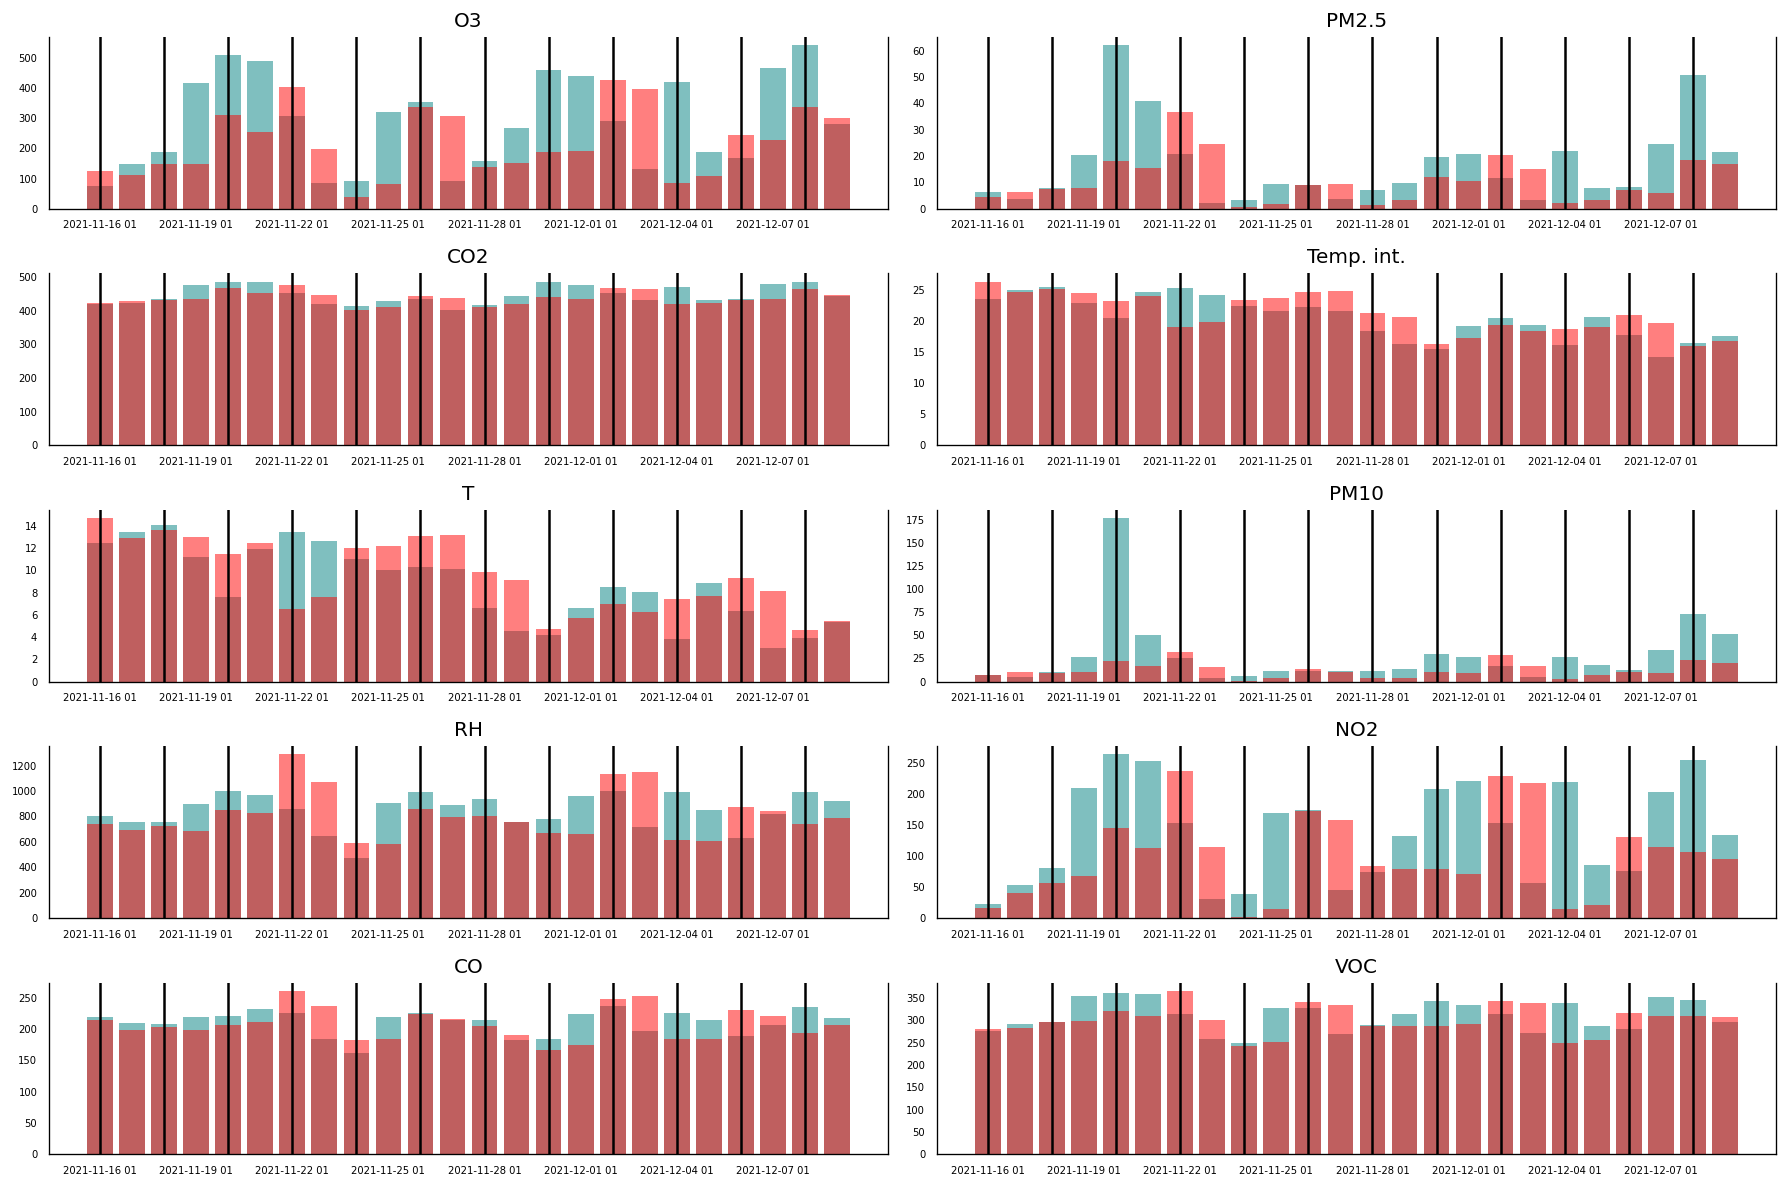

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

if(len(df_train.columns)==10):
  num_row=5
else:
  num_row=6
x_ticks = np.arange(0, to_predict, 3)
# Plot
fig, axes = plt.subplots(nrows=num_row, ncols=2, dpi=120, figsize=(15,10))
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
  if(i<len(df_train.columns)):
    data_for = df_test[df_test.columns[i]]
    data_res_fc=res_fc[res_fc.columns[i]]
    ax.bar(data_for.index, data_for, alpha=0.5,color='teal', linewidth=1)
    ax.bar(data_res_fc.index, data_res_fc, alpha=0.5,color='red', linewidth=1)
    for j in range(len(for_index)):
      ax.axvline(for_index[j]	, color='black')
    # Decorations
    ax.set_title(df_copy.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.set_xticks(x_ticks)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import acf
def adjust(val, length= 6): return str(val).ljust(length)

def forecast_accuracy(forecast, actual):
    if(all (np.abs(actual))!=0):
      mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
      mpe = np.mean((forecast - actual)/actual)   # MPE
    else: 
    #10 significa che non è calcolabile perchè actual è nullo
      mape=10
      mpe=10
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    if(all (maxs)!=0):
      minmax = 1 - np.mean(mins/maxs)             # minmax
    else: 
      minmax=10
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,  'minmax':minmax})
for col in df_copy.columns:
  print('Forecast Accuracy of: '+col)
  accuracy_prod = forecast_accuracy(res_fc[col].values, df_test[col])
  for k, v in accuracy_prod.items():
     print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: O3
mape   :  0.6213
me     :  -67.5974
mae    :  148.7443
mpe    :  0.023
rmse   :  178.0454
minmax :  0.4354
Forecast Accuracy of: PM2.5
mape   :  1.1451
me     :  -5.8065
mae    :  11.3738
mpe    :  0.346
rmse   :  15.6263
minmax :  0.5479
Forecast Accuracy of: CO2
mape   :  0.0492
me     :  -9.1264
mae    :  22.4145
mpe    :  -0.0181
rmse   :  27.0281
minmax :  0.0483
Forecast Accuracy of: Temp. int.
mape   :  0.1145
me     :  0.6608
mae    :  2.2384
mpe    :  0.0442
rmse   :  2.7431
minmax :  0.1017
Forecast Accuracy of: T
mape   :  0.3484
me     :  0.8397
mae    :  2.362
mpe    :  0.211
rmse   :  2.942
minmax :  0.2333
Forecast Accuracy of: PM10
mape   :  0.7476
me     :  -15.2188
mae    :  19.2371
mpe    :  -0.0909
rmse   :  36.2539
minmax :  0.533
Forecast Accuracy of: RH
mape   :  0.2324
me     :  -39.7682
mae    :  191.0682
mpe    :  -0.0182
rmse   :  230.7572
minmax :  0.1977
Forecast Accuracy of: NO2
mape   :  0.8006
me     :  -38.9231
mae    :  87.696


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
